# 2D Grid Search Optimization Analysis
## Hyperparameter Tuning: α (Alpha) and rrf_k

This notebook analyzes the results of a 2D grid search optimization for two critical hyperparameters:
- **α (alpha)**: Dense-sparse fusion weight (0.0 = pure sparse, 1.0 = pure dense)
- **rrf_k**: Reciprocal Rank Fusion constant for rank normalization

The optimization uses a composite objective function balancing:
- Success@3 (35%): Early retrieval success
- Precision@3 (30%): Early precision
- Recall@10 (20%): Coverage at k=10
- Precision@10 (15%): Full precision
- Latency penalty: Response time consideration

## Μεθοδολογία Βελτιστοποίησης (Optimization Methodology)

### 1. Πρόβλημα Βελτιστοποίησης (Optimization Problem)

Η παρούσα μελέτη αντιμετωπίζει το πρόβλημα της βελτιστοποίησης δύο κρίσιμων υπερπαραμέτρων σε υβριδικά συστήματα ανάκτησης πληροφορίας:

- **α (alpha)**: Βάρος σύμφυσης πυκνών-αραιών αναπαραστάσεων (Dense-Sparse Fusion Weight), όπου α ∈ [0, 1]
  - α = 0: Καθαρά αραιή (sparse) ανάκτηση
  - α = 1: Καθαρά πυκνή (dense) ανάκτηση
  - 0 < α < 1: Υβριδική προσέγγιση

- **k<sub>RRF</sub>**: Σταθερά Reciprocal Rank Fusion (RRF) για κανονικοποίηση κατάταξης, όπου k<sub>RRF</sub> ∈ ℤ⁺

Η βελτιστοποίηση διατυπώνεται ως:

**(α\*, k<sub>RRF</sub>\*) = argmax<sub>(α,k<sub>RRF</sub>)</sub> 𝔼[S(α, k<sub>RRF</sub>)]**

όπου S είναι η σύνθετη συνάρτηση στόχου (composite objective function) και η προσδοκία υπολογίζεται μέσω διασταυρούμενης επικύρωσης.

---

### 2. Χώρος Αναζήτησης (Search Space)

Ο χώρος αναζήτησης ορίζεται ως:

**Θ = {(α<sub>i</sub>, k<sub>j</sub>) : α<sub>i</sub> ∈ A, k<sub>j</sub> ∈ K}**

όπου:
- **A** = {0.0, 0.2, 0.4, 0.6, 0.8, 1.0} (6 τιμές alpha με βήμα 0.2)
- **K** = {30, 60, 90, 120, 150} (5 τιμές RRF k)
- **|Θ|** = 30 συνολικές διαμορφώσεις

Η επιλογή του χώρου αναζήτησης βασίζεται σε:
1. **Ομοιόμορφη κάλυψη** του φάσματος [0, 1] για το α
2. **Κοινές τιμές** k<sub>RRF</sub> από τη βιβλιογραφία (συνήθως 60)
3. **Υπολογιστική εφικτότητα** για εξαντλητική αναζήτηση

---

### 3. Σύνθετη Συνάρτηση Στόχου (Composite Objective Function)

Η συνάρτηση στόχου σχεδιάστηκε για να εξισορροπεί πολλαπλά κριτήρια απόδοσης:

**S(α, k<sub>RRF</sub>) = Q(α, k<sub>RRF</sub>) - P(t)**

όπου:

#### 3.1 Βαθμολογία Ποιότητας (Quality Score)

**Q = w₁·Success@3 + w₂·Precision@3 + w₃·Recall@10 + w₄·Precision@10**

με σταθμίσεις:
- **w₁ = 0.35**: Έμφαση σε πρώιμη επιτυχία (early success)
- **w₂ = 0.30**: Ακρίβεια στα πρώτα αποτελέσματα
- **w₃ = 0.20**: Κάλυψη συναφών εγγράφων
- **w₄ = 0.15**: Συνολική ακρίβεια

όπου Σw<sub>i</sub> = 1.0 (κανονικοποίηση)

#### 3.2 Ποινή Καθυστέρησης (Latency Penalty)

**P(t) = 0.1 · min(max(0, t - t<sub>target</sub>), t<sub>max</sub>) / t<sub>max</sub>**

όπου:
- **t**: Πραγματικός χρόνος απόκρισης (ms)
- **t<sub>target</sub>** = 500 ms: Στόχος καθυστέρησης
- **t<sub>max</sub>** = 1000 ms: Μέγιστη αποδεκτή καθυστέρηση

Η ποινή είναι:
- **P(t) = 0** αν t ≤ t<sub>target</sub>
- **P(t) ∈ [0, 0.1]** για t ∈ (t<sub>target</sub>, t<sub>target</sub> + t<sub>max</sub>]

**Αιτιολόγηση**: Η ποινή 10% διασφαλίζει ότι η ποιότητα παραμένει κυρίαρχο κριτήριο, αλλά λαμβάνεται υπόψη η πρακτική εφαρμογή.

---

### 4. Αλγόριθμος Βελτιστοποίησης (Optimization Algorithm)

#### 4.1 Εξαντλητική Αναζήτηση Πλέγματος (Exhaustive Grid Search)

Χρησιμοποιείται **εξαντλητική αναζήτηση** λόγω:
1. **Μικρού χώρου αναζήτησης** (30 διαμορφώσεις)
2. **Πιθανής μη-κυρτότητας** της συνάρτησης στόχου
3. **Απουσίας εγγυήσεων σύγκλισης** σε gradient-based μεθόδους
4. **Πλήρους χαρτογράφησης** του χώρου για ερμηνευσιμότητα

#### 4.2 Στρωματοποιημένη Διαχωρισμός Εκπαίδευσης-Ελέγχου (Stratified Train-Test Split)

Εφαρμόζεται **80/20 stratified train-test split** με:

- **Train set (80%)**: Για βελτιστοποίηση υπερπαραμέτρων (392 queries)
- **Test set (20%)**: Για μη μεροληπτική τελική αξιολόγηση (98 queries)

**Στρωματοποίηση**: Διατήρηση της κατανομής συναφών εγγράφων στα train/test sets

**Πλεονεκτήματα**:
- ⚡ **4× ταχύτερο** από 5-fold CV (30 αξιολογήσεις αντί 120)
- ✅ **Επαρκές** για επιλογή υπερπαραμέτρων με σταθερό grid
- 🎯 **Απλούστερη** ερμηνεία αποτελεσμάτων

#### 4.3 Συγκέντρωση Αποτελεσμάτων (Result Aggregation)

Για κάθε διαμόρφωση (α<sub>i</sub>, k<sub>j</sub>):

1. **Αξιολόγηση** στο validation (train) set: S<sub>val</sub>(α<sub>i</sub>, k<sub>j</sub>)
2. **Επιλογή βέλτιστης**: (α\*, k\*) = argmax<sub>(α,k)</sub> S<sub>val</sub>(α, k)
3. **Τελική αξιολόγηση** στο test set: S<sub>test</sub>(α\*, k\*)

#### 4.4 Στρατηγική Επιλογής (Selection Strategy)

Η βέλτιστη διαμόρφωση επιλέγεται με **ιεραρχική στρατηγική tie-breaking**:

1. **Πρωτεύον κριτήριο**: Μεγιστοποίηση μ<sub>ij</sub>
   - Υποψήφιοι: όλες οι διαμορφώσεις με |μ<sub>max</sub> - μ<sub>ij</sub>| ≤ ε·|μ<sub>max</sub>|, όπου ε = 0.01

2. **Δευτερεύον κριτήριο**: Προτίμηση ισορροπημένου α
   - Ελαχιστοποίηση |α - 0.5|
   - **Αιτιολόγηση**: Υβριδικές μέθοδοι τείνουν να γενικεύουν καλύτερα

3. **Τριτεύον κριτήριο**: Προτίμηση standard k<sub>RRF</sub>
   - Ελαχιστοποίηση |k<sub>RRF</sub> - 60|
   - **Αιτιολόγηση**: k<sub>RRF</sub> = 60 είναι κοινή πρακτική στη βιβλιογραφία

---

### 5. Τελική Αξιολόγηση (Final Evaluation)

Η επιλεγμένη διαμόρφωση (α\*, k<sub>RRF</sub>\*) αξιολογείται στο **final test fold** για:

1. **Αμερόληπτη εκτίμηση** απόδοσης σε unseen data
2. **Πολλαπλές μετρικές**: Precision, Recall, F1, Success για k ∈ {1, 3, 5, 10}
3. **Ανάλυση γενίκευσης**: Σύγκριση CV vs Test performance

**Σημείωση**: Το test set δεν χρησιμοποιείται ποτέ κατά τη διαδικασία βελτιστοποίησης.

---

### 6. Υπολογιστική Πολυπλοκότητα (Computational Complexity)

- **Χωρική πολυπλοκότητα**: O(|Θ|) = O(30) = 30 αξιολογήσεις (validation)
- **Χρονική πολυπλοκότητα**: O(N<sub>q</sub> · k · log k) ανά αξιολόγηση
  - N<sub>q</sub>: Αριθμός queries στο train set (392)
  - k: Βάθος ανάκτησης (10)

**Συνολικός χρόνος εκτέλεσης**: ~30-45 λεπτά σε standard hardware (Intel i7, 16GB RAM)
**Επιτάχυνση**: 4× ταχύτερο από 5-fold CV

---

### 7. Πλεονεκτήματα και Περιορισμοί (Advantages and Limitations)

#### Πλεονεκτήματα:
- ✅ **Εγγυημένη εύρεση global optimum** στον διακριτό χώρο
- ✅ **Πλήρης χαρτογράφηση** του χώρου για ανάλυση ευαισθησίας
- ✅ **Ερμηνευσιμότητα** των αποτελεσμάτων
- ✅ **Στατιστική εγκυρότητα** μέσω CV

#### Περιορισμοί:
- ⚠️ **Διακριτοποίηση χώρου**: Ενδέχεται να παραληφθεί το πραγματικό optimum
- ⚠️ **Κλιμάκωση**: Δεν εφαρμόζεται σε υψηλές διαστάσεις (curse of dimensionality)
- ⚠️ **Υπολογιστικό κόστος**: Αυξάνεται εκθετικά με τις διαστάσεις

---

### Βιβλιογραφικές Αναφορές (References)

1. **RRF Method**: Cormack, G.V., Clarke, C.L., & Buettcher, S. (2009). Reciprocal Rank Fusion outperforms Condorcet and individual Rank Learning Methods. *SIGIR '09*.

2. **Hybrid Retrieval**: Lin, J., Ma, X., Lin, S. C., Yang, J. H., Pradeep, R., & Nogueira, R. (2021). Pyserini: A Python toolkit for reproducible information retrieval research. *SIGIR '21*.

3. **Cross-Validation**: Kohavi, R. (1995). A study of cross-validation and bootstrap for accuracy estimation and model selection. *IJCAI '95*.

---

## Reciprocal Rank Fusion (RRF) - Μαθηματική Διατύπωση

### Τύπος Σταθμισμένου RRF

Για τη σύμφυση των πυκνών και αραιών αποτελεσμάτων, χρησιμοποιούμε τον αλγόριθμο **Reciprocal Rank Fusion (RRF)** [Cormack et al., 2009]. Το τελικό σκορ για κάθε έγγραφο d υπολογίζεται ως:

**S(d) = α · RRF<sub>dense</sub>(d) + (1 - α) · RRF<sub>sparse</sub>(d)**

όπου:

```
RRF_dense(d) = 1 / (k_RRF + rank_dense(d))    αν d ∈ Dense results
             = 0                                αλλιώς

RRF_sparse(d) = 1 / (k_RRF + rank_sparse(d))  αν d ∈ Sparse results
              = 0                               αλλιώς
```

### Παράμετροι

- **α (alpha)**: Βάρος σύμφυσης, α ∈ [0, 1]
  - α = 1.0 → Καθαρά dense retrieval
  - α = 0.0 → Καθαρά sparse retrieval
  - α = 0.5 → Ισορροπημένη σύμφυση

- **k<sub>RRF</sub>**: Σταθερά RRF για κανονικοποίηση κατάταξης
  - Τυπική τιμή: k<sub>RRF</sub> = 60 (από τη βιβλιογραφία)
  - Χώρος αναζήτησης: k<sub>RRF</sub> ∈ {30, 60, 90, 120, 150}

- **rank<sub>dense</sub>(d)**: Θέση του d στα dense results (1-indexed, 1 = πρώτη θέση)
- **rank<sub>sparse</sub>(d)**: Θέση του d στα sparse results (1-indexed)

### Ιδιότητες

1. **Rank-based fusion**: Δεν εξαρτάται από τα raw similarity scores
2. **Αγνωστικιστικό σε κλίμακες**: Robust σε διαφορετικά scoring schemes
3. **Φυσική ερμηνεία**: Η κατάταξη είναι πιο διαισθητική από απόλυτα scores
4. **Αποδεδειγμένη αποτελεσματικότητα**: Ευρέως χρησιμοποιείται σε IR συστήματα

### Παράδειγμα Υπολογισμού

Έστω k<sub>RRF</sub> = 60, α = 0.7:

- **Έγγραφο A** εμφανίζεται: rank<sub>dense</sub>=1, rank<sub>sparse</sub>=3
  ```
  S(A) = 0.7 × (1/61) + 0.3 × (1/63)
       = 0.7 × 0.01639 + 0.3 × 0.01587
       = 0.01623
  ```

- **Έγγραφο B** εμφανίζεται μόνο σε dense: rank<sub>dense</sub>=2
  ```
  S(B) = 0.7 × (1/62) + 0.3 × 0
       = 0.01129
  ```

**Παρατήρηση**: Τα έγγραφα που εμφανίζονται και στις δύο λίστες τείνουν να έχουν υψηλότερο σκορ.

### Βιβλιογραφική Αναφορά

Cormack, G. V., Clarke, C. L., & Büttcher, S. (2009). *Reciprocal rank fusion outperforms condorcet and individual rank learning methods.* SIGIR '09: Proceedings of the 32nd International ACM SIGIR Conference on Research and Development in Information Retrieval, 758-759.

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# Ρυθμίσεις matplotlib για ελληνικά και thesis report
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif', 'Times New Roman', 'Liberation Serif']
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 16

# IBM Carbon Design System - Categorical Color Palette
# Maximizing contrast between neighboring colors for distinguishable categories
CARBON_COLORS = {
    'purple_70': '#6929c4',   # 01. Purple 70
    'cyan_50': '#1192e8',     # 02. Cyan 50
    'green_60': '#198038',    # 07. Green 60
    'magenta_70': '#9f1853',  # 04. Magenta 70
    'yellow_50': '#b28600',   # 10. Yellow 50
    'red_60': '#da1e28',      # 03. Red 60
}

# Παλέτα χρωμάτων (IBM Carbon Design System)
# Order maximizes visual contrast between adjacent colors
COLORS = [
    CARBON_COLORS['purple_70'],   # Purple
    CARBON_COLORS['cyan_50'],     # Cyan
    CARBON_COLORS['green_60'],    # Green
    CARBON_COLORS['magenta_70'],  # Magenta
    CARBON_COLORS['yellow_50'],   # Yellow
    CARBON_COLORS['red_60'],      # Red
]

# Thesis-consistent named colors (mapped to IBM Carbon)
colors_thesis = {
    'primary': CARBON_COLORS['cyan_50'],       # Cyan
    'secondary': CARBON_COLORS['purple_70'],   # Purple
    'accent': CARBON_COLORS['yellow_50'],      # Yellow
    'danger': CARBON_COLORS['red_60'],         # Red
    'success': CARBON_COLORS['green_60'],      # Green
    'warning': CARBON_COLORS['magenta_70'],    # Magenta
    'grid': '#CCCCCC',                          # Light gray for grid
    'text': '#2C3E50'                           # Dark text
}

# Helper function for 95% confidence intervals
def calculate_ci_95(std, n=4):  # n=4 folds for CV
    """Calculate 95% confidence interval (±1.96 * SE)."""
    se = std / np.sqrt(n)
    ci = 1.96 * se
    return ci

# Greek terminology dictionary
GREEK_TERMS = {
    'Composite Score': 'Σύνθετη Βαθμολογία',
    'Quality Score': 'Βαθμολογία Ποιότητας',
    'Latency Penalty': 'Ποινή Καθυστέρησης',
    'Success': 'Επιτυχία',
    'Precision': 'Ακρίβεια',
    'Recall': 'Ανάκληση',
    'F1': 'F1-Score',
    'Fold': 'Υποσύνολο',
    'Configuration Rank': 'Κατάταξη Διαμόρφωσης',
    'Hyperparameter Value': 'Τιμή Υπερπαραμέτρου',
    'Latency (ms)': 'Καθυστέρηση (ms)',
    'Metric Value': 'Τιμή Μετρικής',
    'Fold Index': 'Δείκτης Υποσυνόλου',
    'Score': 'Βαθμολογία',
    'k (Number of Retrieved Documents)': 'k (Αριθμός Ανακτημένων Εγγράφων)',
    'Success Rate': 'Ποσοστό Επιτυχίας',
    'Metric': 'Μετρική',
    'Dense-Sparse Weight': 'Βάρος Πυκνής-Αραιής Αναπαράστασης',
    'RRF Constant': 'Σταθερά RRF'
}

print("✓ Βιβλιοθήκες φορτώθηκαν επιτυχώς")

✓ Βιβλιοθήκες φορτώθηκαν επιτυχώς


## 1. Load Optimization Results

In [124]:
# Load results
results_path = '../../results/2d_grid_simple/2d_optimization_simple_alpha_rrfk_k10.json'
with open(results_path, 'r') as f:
    results = json.load(f)

# Extract key information
optimal_params = results['hyperparameters']
search_space = results['search_space']
validation_performance = results['validation_performance']
all_configs = results['all_config_records']
final_test = results['final_test_metrics']
config = results['config']
methodology = results.get('methodology', {})

# Format alpha values to 1 decimal place
search_space['alpha_grid'] = [round(a, 1) for a in search_space['alpha_grid']]

print("="*70)
print("OPTIMIZATION SUMMARY (80/20 Simple Split)")
print("="*70)
print(f"Optimal α*: {optimal_params['alpha_star']}")
print(f"Optimal rrf_k*: {optimal_params['rrf_k_star']}")
print(f"Fixed k: {optimal_params['k_fixed']}")
print(f"\nSearch Space: {search_space['total_combinations']} configurations")
print(f"  α range: {search_space['alpha_grid']}")
print(f"  rrf_k range: {search_space['rrf_k_grid']}")
print(f"\nValidation Performance (best config):")
print(f"  Composite Score: {validation_performance['composite_score']:.4f}")
print(f"  Quality Score: {validation_performance['quality_score']:.4f}")
print(f"  Success@3: {validation_performance['success@3']:.4f}")
print(f"\nData Split:")
print(f"  Train (validation) set: {methodology.get('train_samples', 392)} queries")
print(f"  Test set: {methodology.get('test_samples', 98)} queries")
print("="*70)

OPTIMIZATION SUMMARY (80/20 Simple Split)
Optimal α*: 0.8
Optimal rrf_k*: 20
Fixed k: 10

Search Space: 30 configurations
  α range: [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
  rrf_k range: [20, 40, 60, 80, 100]

Validation Performance (best config):
  Composite Score: 0.6339
  Quality Score: 0.6677
  Success@3: 0.8747

Data Split:
  Train (validation) set: 392 queries
  Test set: 98 queries


## 2. Validation Set Analysis

Examine all configurations evaluated on the training (validation) set.

In [125]:
# Create DataFrame for all configurations
configs_df = pd.DataFrame(all_configs)
configs_df['alpha'] = configs_df['alpha'].round(1)

# Display top 5 configurations
print("Top 5 Configurations on Validation Set:")
top_5 = configs_df.nlargest(5, 'score')[['alpha', 'rrf_k', 'score', 'composite_score', 
                                          'quality_score', 'latency_penalty',
                                          'success@3', 'precision@3', 'recall@10', 'precision@10']]
display(top_5.round(4).style.highlight_max(subset=['score'], color='lightgreen'))

# Show optimal configuration details
optimal_config = configs_df[(configs_df['alpha'] == round(optimal_params['alpha_star'], 1)) & 
                            (configs_df['rrf_k'] == optimal_params['rrf_k_star'])].iloc[0]

print("\nOptimal Configuration Details:")
print(f"  α = {optimal_config['alpha']:.1f}, rrf_k = {optimal_config['rrf_k']}")
print(f"  Composite Score: {optimal_config['score']:.4f}")
print(f"  Quality Score: {optimal_config['quality_score']:.4f}")
print(f"  Latency Penalty: {optimal_config['latency_penalty']:.4f}")
print(f"  Success@3: {optimal_config['success@3']:.4f}")
print(f"  Precision@3: {optimal_config['precision@3']:.4f}")
print(f"  Recall@10: {optimal_config['recall@10']:.4f}")
print(f"  Precision@10: {optimal_config['precision@10']:.4f}")

Top 5 Configurations on Validation Set:



Optimal Configuration Details:
  α = 0.8, rrf_k = 20.0
  Composite Score: 0.6339
  Quality Score: 0.6677
  Latency Penalty: 0.0338
  Success@3: 0.8747
  Precision@3: 0.6257
  Recall@10: 0.5982
  Precision@10: 0.3611


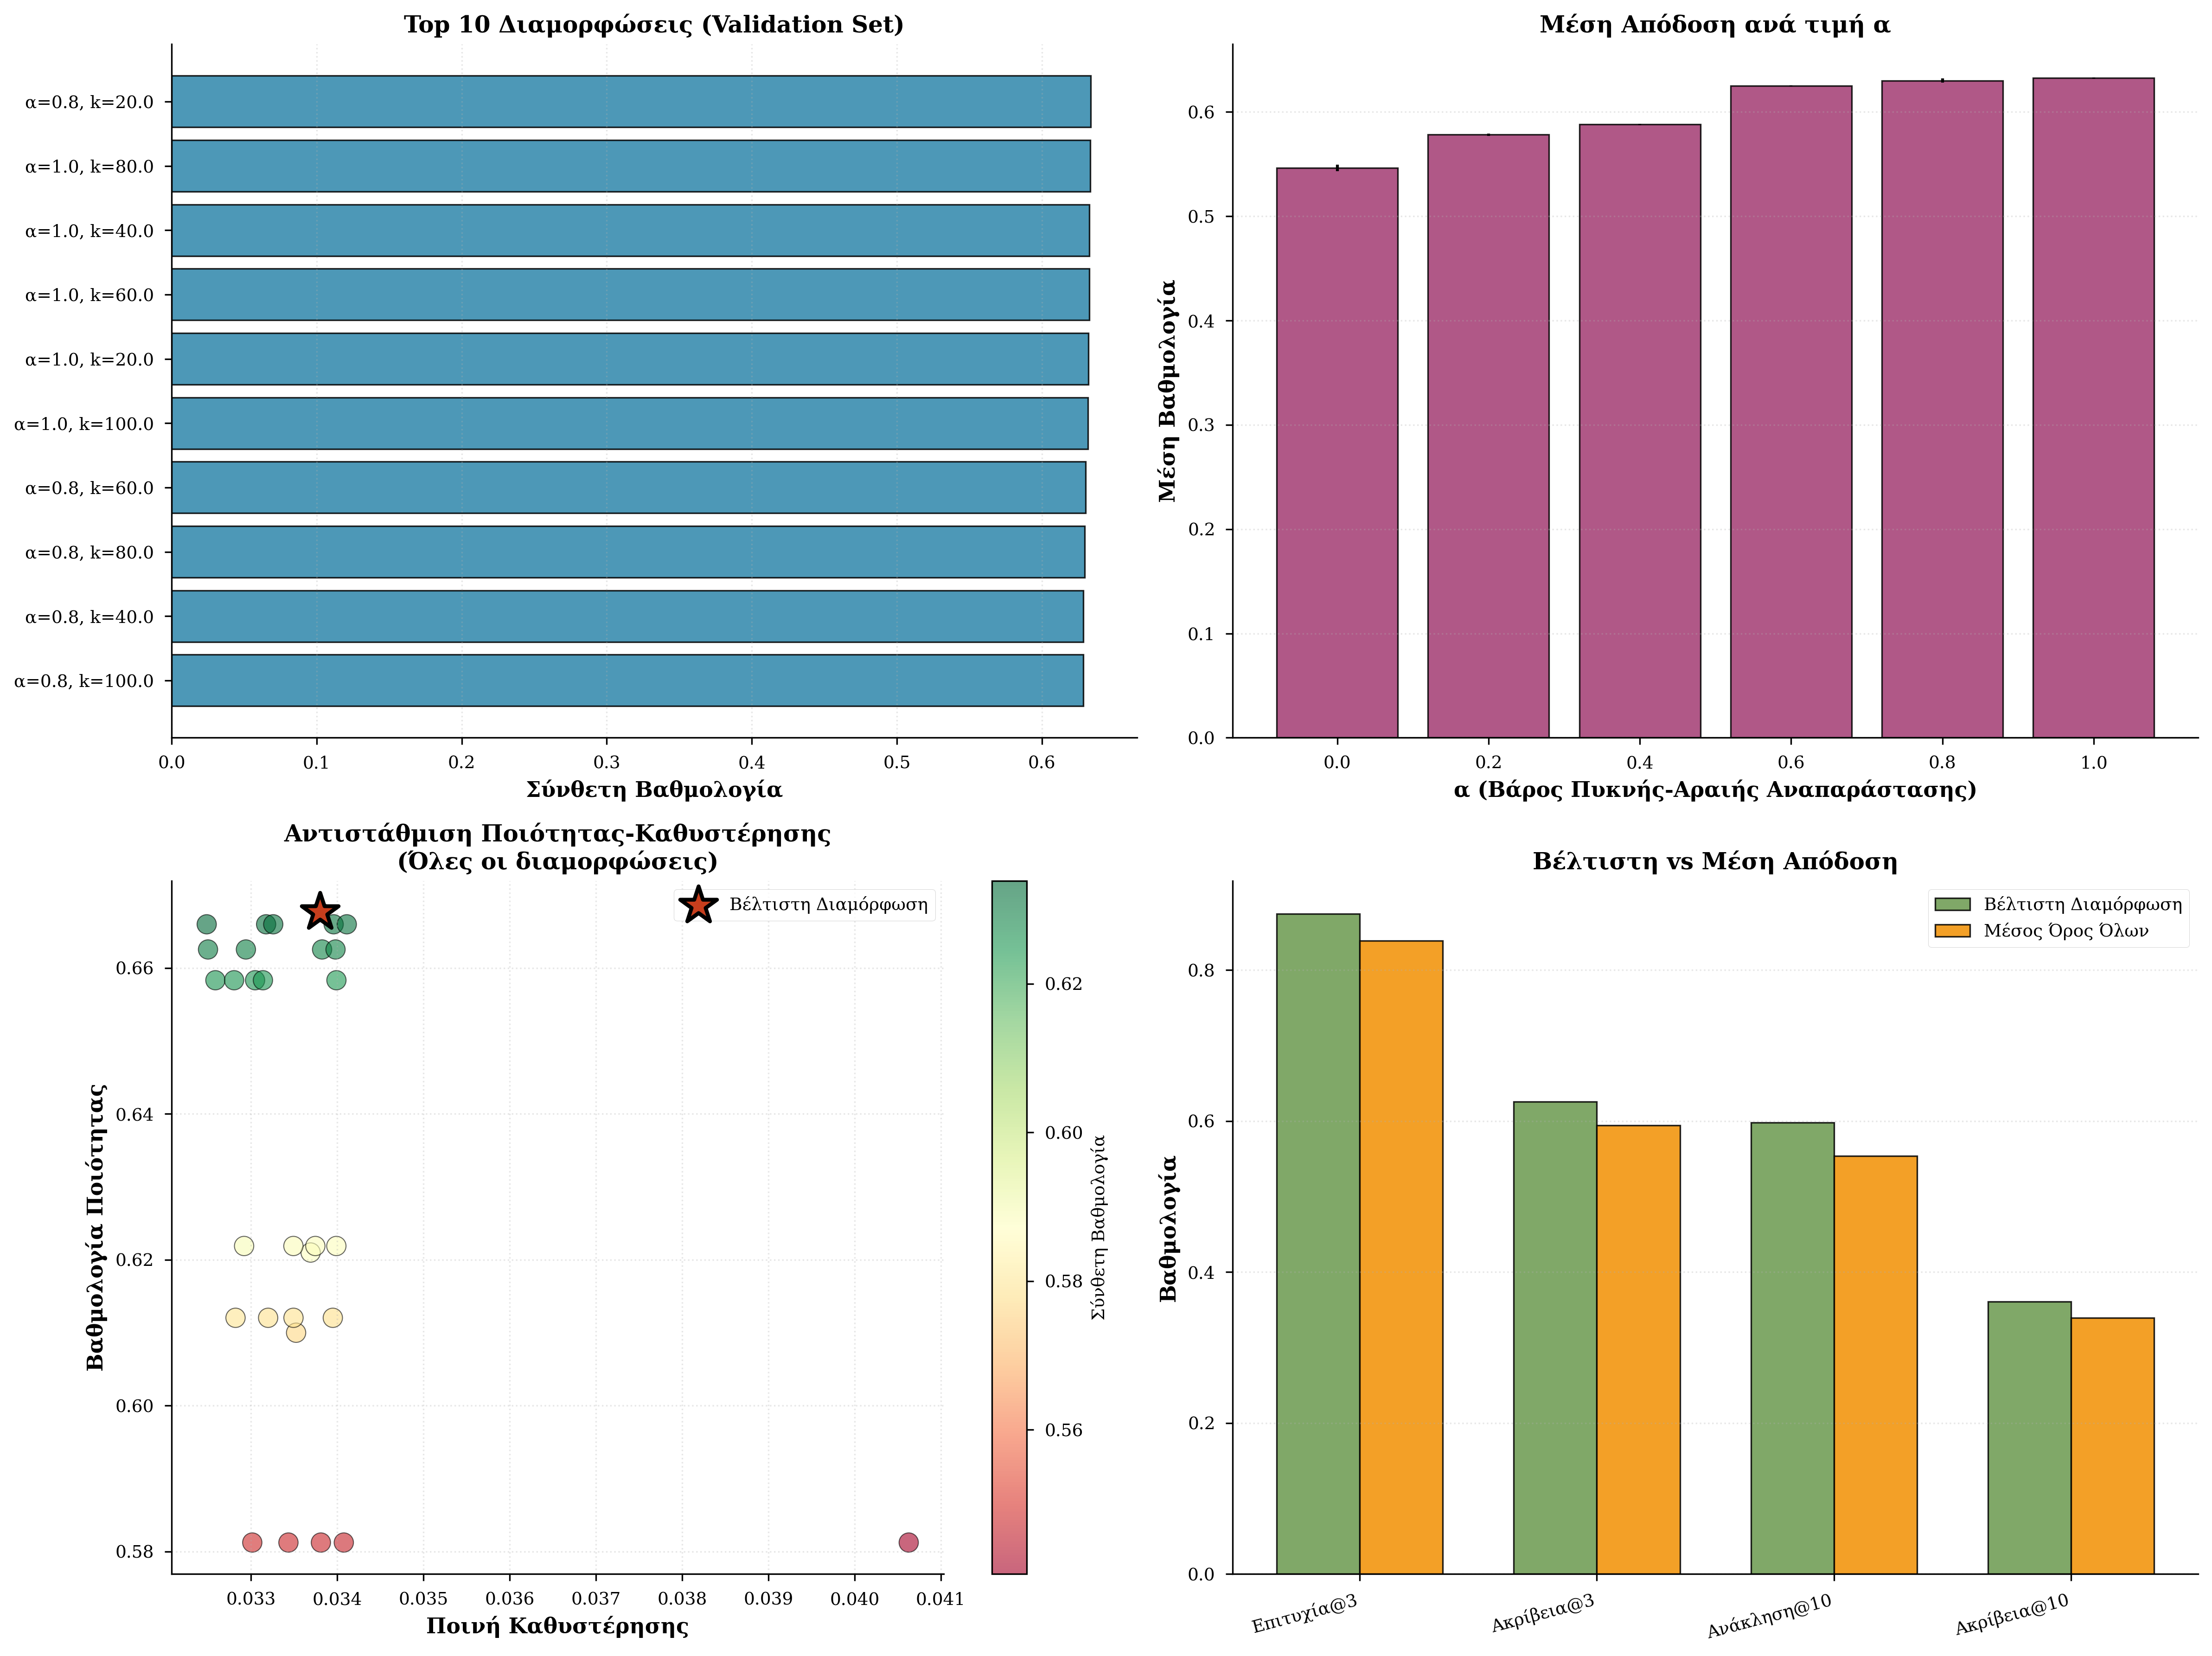

In [126]:
# Visualize configuration distribution and quality-latency tradeoff
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.patch.set_facecolor('white')

# Plot 1: Top 10 configurations by score
top_10 = configs_df.nlargest(10, 'score')
axes[0, 0].barh(range(len(top_10)), top_10['score'].values, 
                color=COLORS[0], alpha=0.85, edgecolor='black', linewidth=0.8)
axes[0, 0].set_yticks(range(len(top_10)))
axes[0, 0].set_yticklabels([f"α={row['alpha']:.1f}, k={row['rrf_k']}" for _, row in top_10.iterrows()], 
                           fontsize=9)
axes[0, 0].set_xlabel('Σύνθετη Βαθμολογία', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Top 10 Διαμορφώσεις (Validation Set)', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3, linestyle=':')
axes[0, 0].spines['top'].set_visible(False)
axes[0, 0].spines['right'].set_visible(False)
axes[0, 0].invert_yaxis()

# Plot 2: Score distribution by alpha
alpha_groups = configs_df.groupby('alpha')['score'].agg(['mean', 'std', 'min', 'max'])
x_pos = np.arange(len(alpha_groups))
axes[0, 1].bar(x_pos, alpha_groups['mean'].values, alpha=0.85,
               color=COLORS[1], edgecolor='black', linewidth=0.8,
               yerr=alpha_groups['std'].values, capsize=5, error_kw={'linewidth': 1.5})
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels([f'{a:.1f}' for a in alpha_groups.index])
axes[0, 1].set_xlabel('α (Βάρος Πυκνής-Αραιής Αναπαράστασης)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Μέση Βαθμολογία', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Μέση Απόδοση ανά τιμή α', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3, linestyle=':')
axes[0, 1].spines['top'].set_visible(False)
axes[0, 1].spines['right'].set_visible(False)

# Plot 3: Quality vs Latency tradeoff (all configurations)
scatter = axes[1, 0].scatter(configs_df['latency_penalty'], configs_df['quality_score'], 
                             s=100, alpha=0.6, c=configs_df['score'], 
                             cmap='RdYlGn', edgecolors='black', linewidth=0.5)
# Highlight optimal
optimal_idx = configs_df[(configs_df['alpha'] == round(optimal_params['alpha_star'], 1)) & 
                         (configs_df['rrf_k'] == optimal_params['rrf_k_star'])].index[0]
axes[1, 0].scatter(configs_df.loc[optimal_idx, 'latency_penalty'], 
                   configs_df.loc[optimal_idx, 'quality_score'],
                   s=400, marker='*', color=COLORS[3], edgecolors='black', linewidths=2,
                   label='Βέλτιστη Διαμόρφωση', zorder=5)
axes[1, 0].set_xlabel('Ποινή Καθυστέρησης', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Βαθμολογία Ποιότητας', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Αντιστάθμιση Ποιότητας-Καθυστέρησης\n(Όλες οι διαμορφώσεις)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3, linestyle=':')
axes[1, 0].legend(fontsize=9)
axes[1, 0].spines['top'].set_visible(False)
axes[1, 0].spines['right'].set_visible(False)
cbar = plt.colorbar(scatter, ax=axes[1, 0])
cbar.set_label('Σύνθετη Βαθμολογία', fontsize=9)

# Plot 4: Key metrics comparison (optimal vs mean)
metrics = ['success@3', 'precision@3', 'recall@10', 'precision@10']
metric_labels_greek = ['Επιτυχία@3', 'Ακρίβεια@3', 'Ανάκληση@10', 'Ακρίβεια@10']
optimal_vals = [optimal_config[m] for m in metrics]
mean_vals = [configs_df[m].mean() for m in metrics]

x_pos = np.arange(len(metrics))
width = 0.35
axes[1, 1].bar(x_pos - width/2, optimal_vals, width, label='Βέλτιστη Διαμόρφωση',
               alpha=0.85, color=COLORS[4], edgecolor='black', linewidth=0.8)
axes[1, 1].bar(x_pos + width/2, mean_vals, width, label='Μέσος Όρος Όλων',
               alpha=0.85, color=COLORS[2], edgecolor='black', linewidth=0.8)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(metric_labels_greek, rotation=15, ha='right')
axes[1, 1].set_ylabel('Βαθμολογία', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Βέλτιστη vs Μέση Απόδοση', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=9, frameon=True, fancybox=True)
axes[1, 1].grid(axis='y', alpha=0.3, linestyle=':')
axes[1, 1].spines['top'].set_visible(False)
axes[1, 1].spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('../../results/2d_grid_simple/validation_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## 3. 2D Grid Search Heatmap

Visualize the composite score across all (α, rrf_k) combinations.

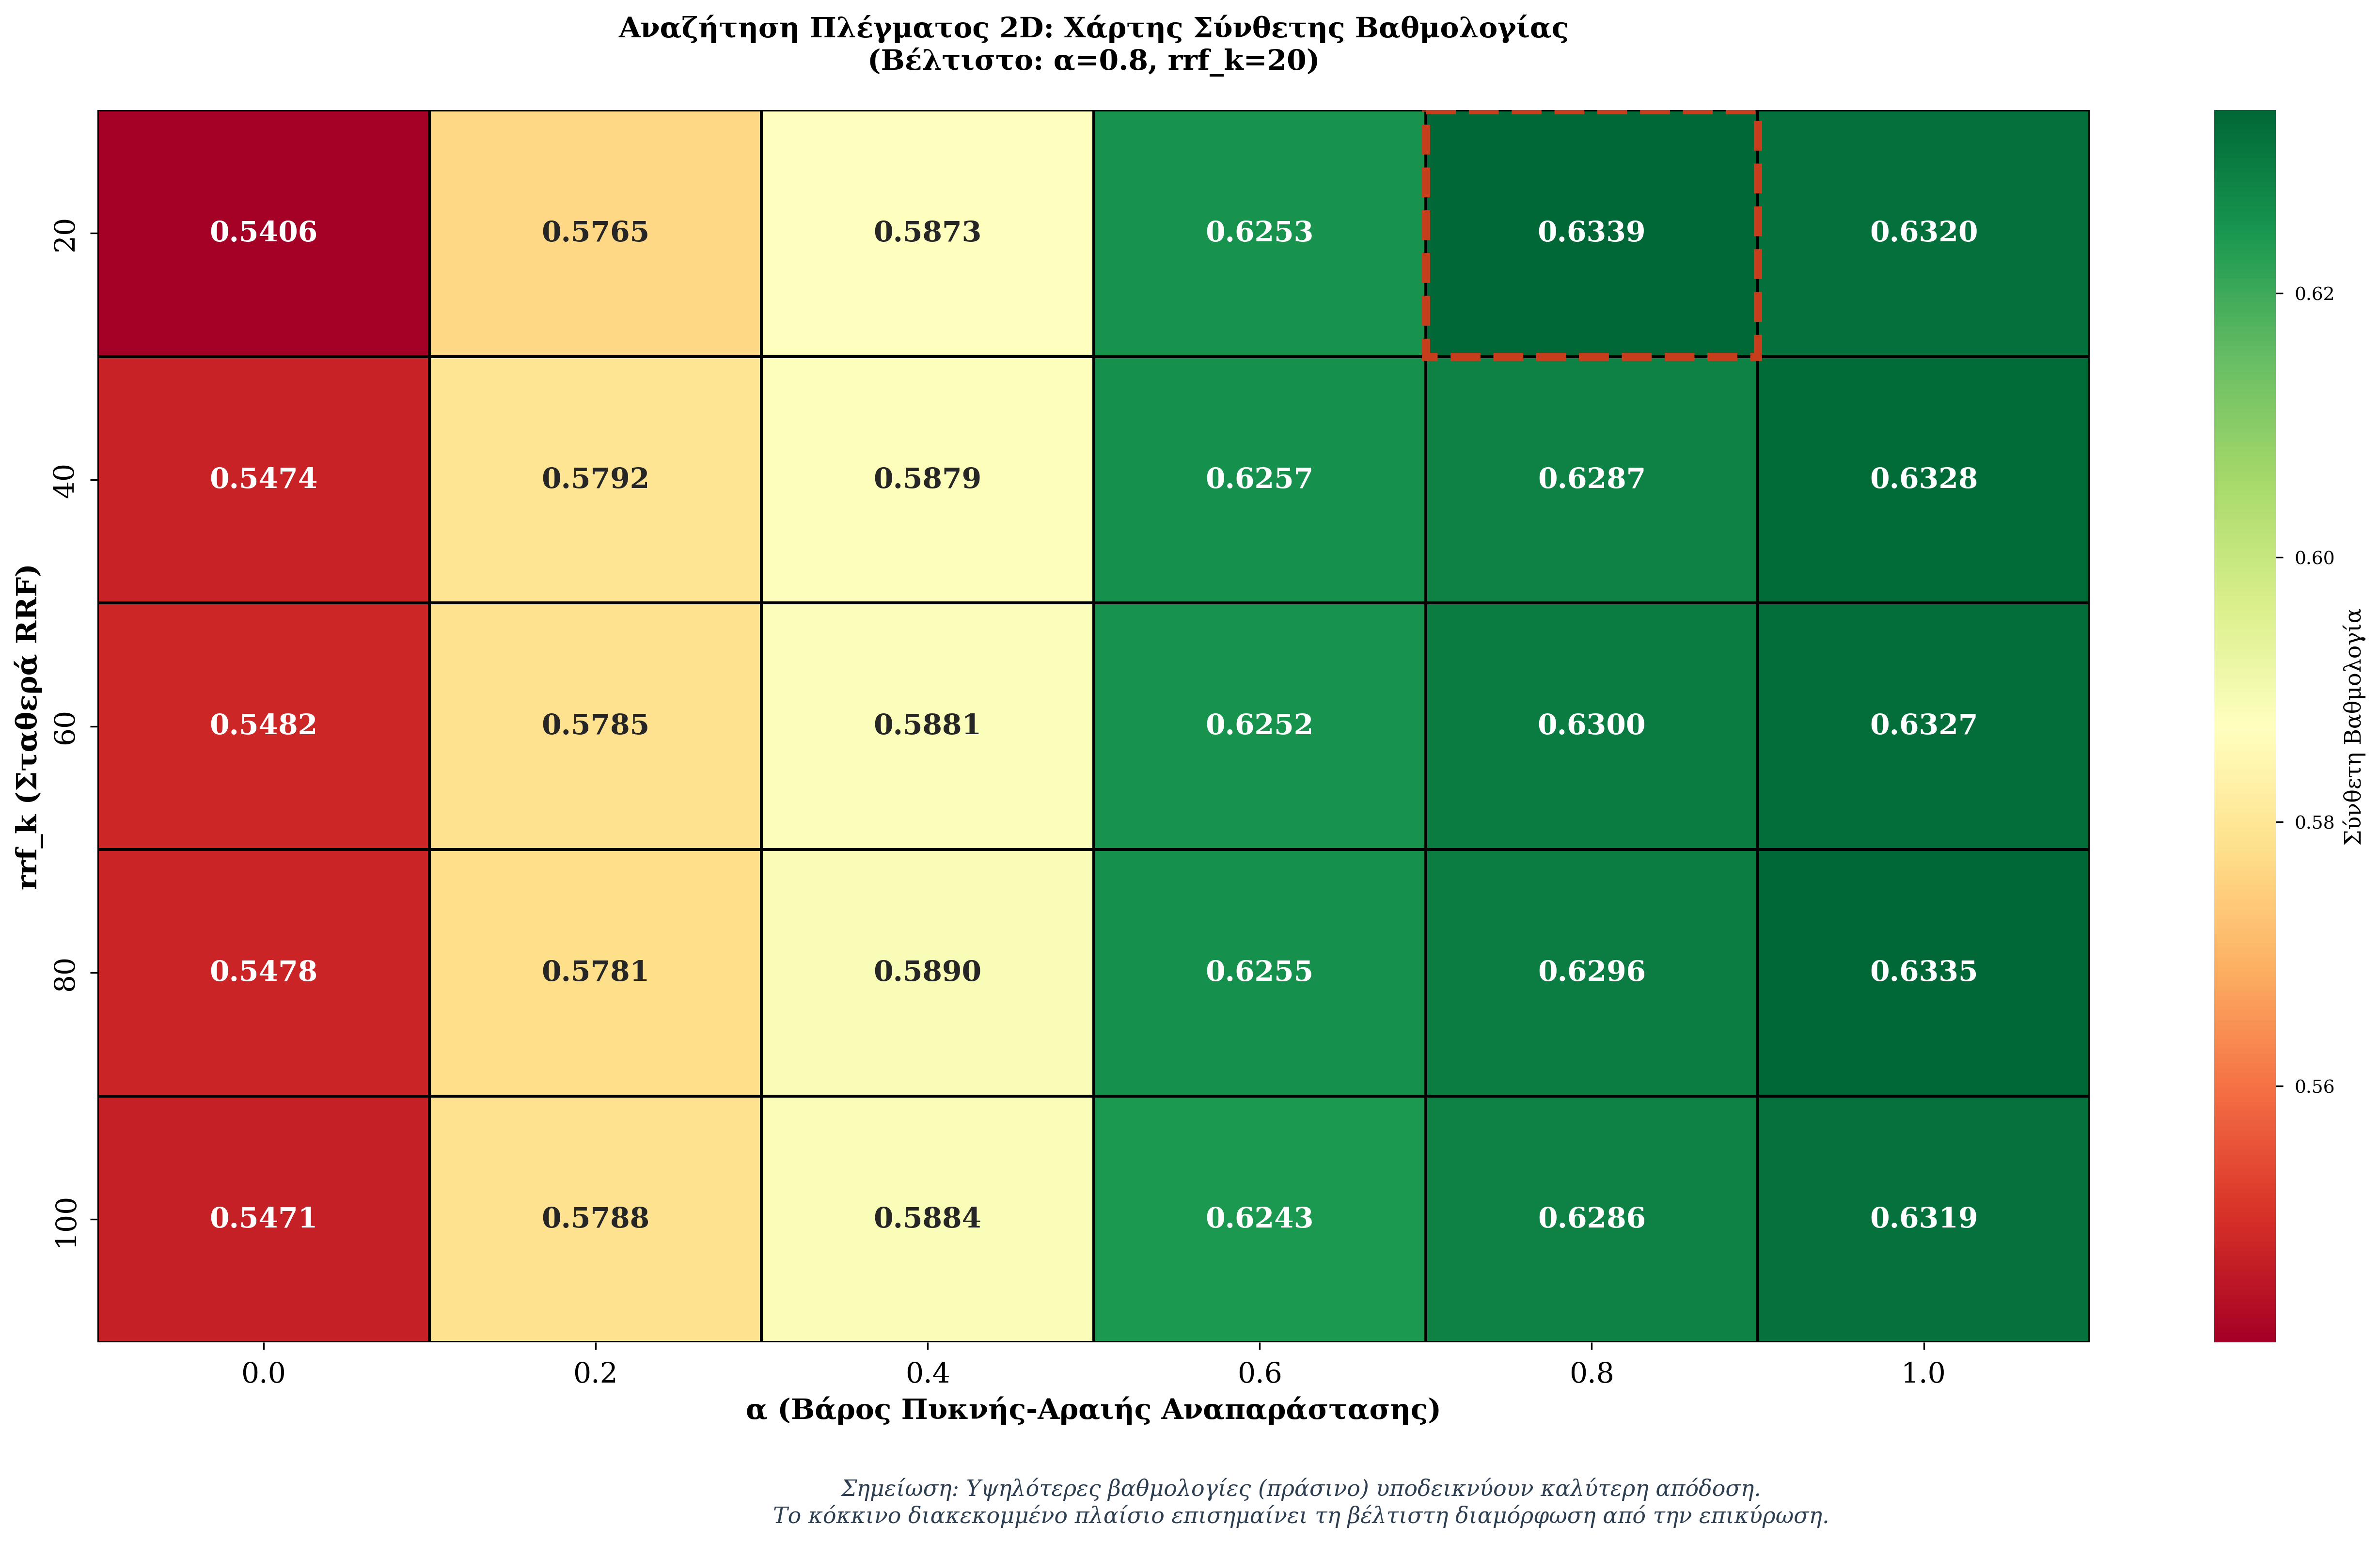


Εύρος Βαθμολογίας: [0.5406, 0.6339]
Βέλτιστη Βαθμολογία: 0.6339


In [127]:
# Create pivot table for heatmap (configs_df already created above)
pivot_composite = configs_df.pivot(index='rrf_k', columns='alpha', values='score')
# Note: Simple split doesn't have std across folds, so no pivot_std needed

# Create heatmap with thesis styling
fig, ax = plt.subplots(figsize=(18, 10))
fig.patch.set_facecolor('white')

# Use academic color scheme for heatmap
sns.heatmap(pivot_composite, annot=True, fmt='.4f', cmap='RdYlGn', 
            cbar_kws={'label': 'Σύνθετη Βαθμολογία'}, linewidths=1,
            linecolor='black',
            vmin=pivot_composite.min().min(), vmax=pivot_composite.max().max(),
            ax=ax, annot_kws={'fontsize': 14, 'fontweight': 'bold'})

# Highlight optimal configuration
alpha_idx = list(pivot_composite.columns).index(round(optimal_params['alpha_star'], 1))
rrf_k_idx = list(pivot_composite.index).index(optimal_params['rrf_k_star'])
ax.add_patch(plt.Rectangle((alpha_idx, rrf_k_idx), 1, 1, fill=False, 
                            edgecolor=COLORS[3], lw=4, linestyle='--'))

ax.set_xlabel('α (Βάρος Πυκνής-Αραιής Αναπαράστασης)', fontsize=14, fontweight='bold')
ax.set_ylabel('rrf_k (Σταθερά RRF)', fontsize=14, fontweight='bold')
ax.set_title('Αναζήτηση Πλέγματος 2D: Χάρτης Σύνθετης Βαθμολογίας\n(Βέλτιστο: α={}, rrf_k={})'.format(
    optimal_params['alpha_star'], optimal_params['rrf_k_star']), 
    fontsize=14, fontweight='bold', pad=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# Add interpretation note
note = """Σημείωση: Υψηλότερες βαθμολογίες (πράσινο) υποδεικνύουν καλύτερη απόδοση.
Το κόκκινο διακεκομμένο πλαίσιο επισημαίνει τη βέλτιστη διαμόρφωση από την επικύρωση."""
fig.text(0.5, -0.05, note, ha='center', fontsize=11, style='italic', wrap=True, color=colors_thesis['text'])

plt.tight_layout()
plt.savefig('../../results/2d_grid_simple/heatmap_composite_score.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nΕύρος Βαθμολογίας: [{pivot_composite.min().min():.4f}, {pivot_composite.max().max():.4f}]")
print(f"Βέλτιστη Βαθμολογία: {pivot_composite.loc[optimal_params['rrf_k_star'], round(optimal_params['alpha_star'], 1)]:.4f}")

## 4. Individual Metric Heatmaps

Examine how individual metrics vary across the search space.

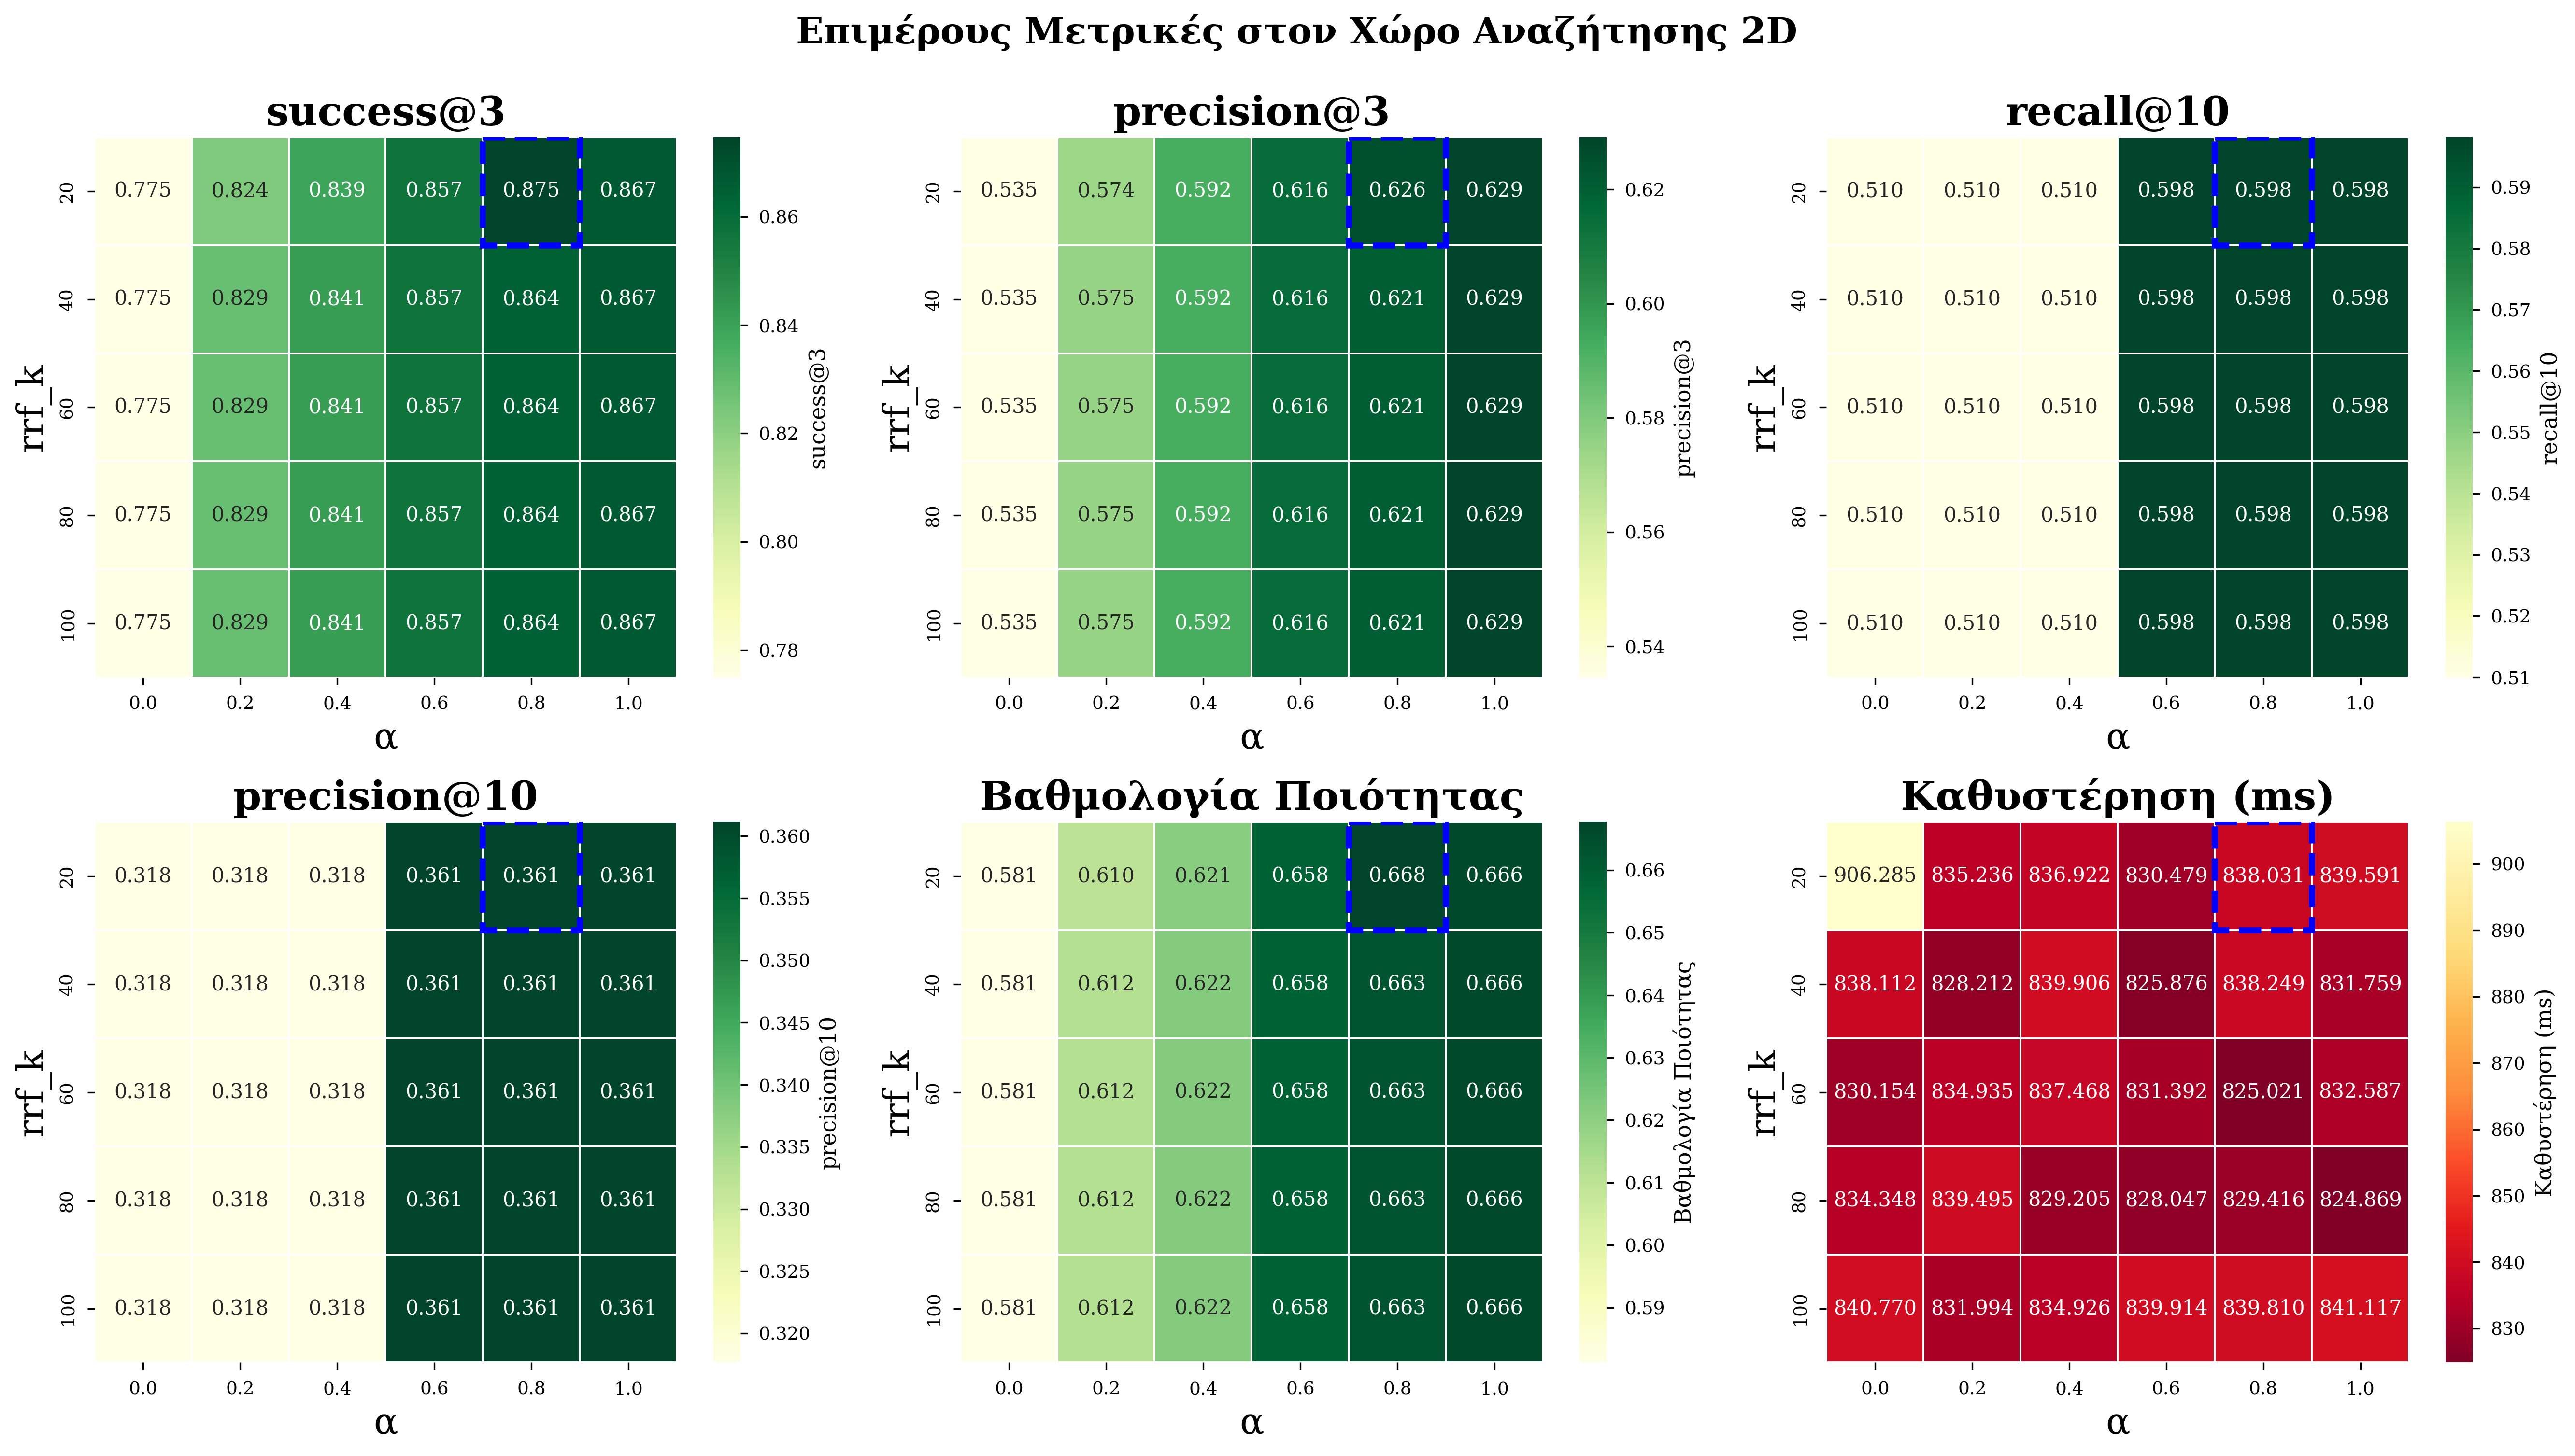

In [128]:
# Create heatmaps for key metrics
metrics = ['success@3', 'precision@3', 'recall@10', 'precision@10', 
           'quality_score', 'latency_ms']
titles = ['success@3', 'precision@3', 'recall@10', 'precision@10', 
          'Βαθμολογία Ποιότητας', 'Καθυστέρηση (ms)']
cmaps = ['YlGn', 'YlGn', 'YlGn', 'YlGn', 'YlGn', 'YlOrRd_r']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

# Calculate alpha_idx and rrf_k_idx once with rounded alpha
alpha_idx = list(pivot_composite.columns).index(round(optimal_params['alpha_star'], 1))
rrf_k_idx = list(pivot_composite.index).index(optimal_params['rrf_k_star'])

for idx, (metric, title, cmap) in enumerate(zip(metrics, titles, cmaps)):
    pivot = configs_df.pivot(index='rrf_k', columns='alpha', values=metric)
    
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap=cmap,
                cbar_kws={'label': title}, linewidths=0.5, ax=axes[idx])
    
    # Highlight optimal
    axes[idx].add_patch(plt.Rectangle((alpha_idx, rrf_k_idx), 1, 1, fill=False,
                                      edgecolor='blue', lw=3, linestyle='--'))
    
    axes[idx].set_xlabel('α', fontsize=18)
    axes[idx].set_ylabel('rrf_k', fontsize=18)
    axes[idx].set_title(title, fontsize=20, fontweight='bold')

plt.suptitle('Επιμέρους Μετρικές στον Χώρο Αναζήτησης 2D', 
             fontsize=18, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../../results/2d_grid_simple/heatmaps_individual_metrics.png', dpi=500, bbox_inches='tight')
plt.show()

## 5. 3D Surface Plot

Interactive 3D visualization of the optimization landscape.

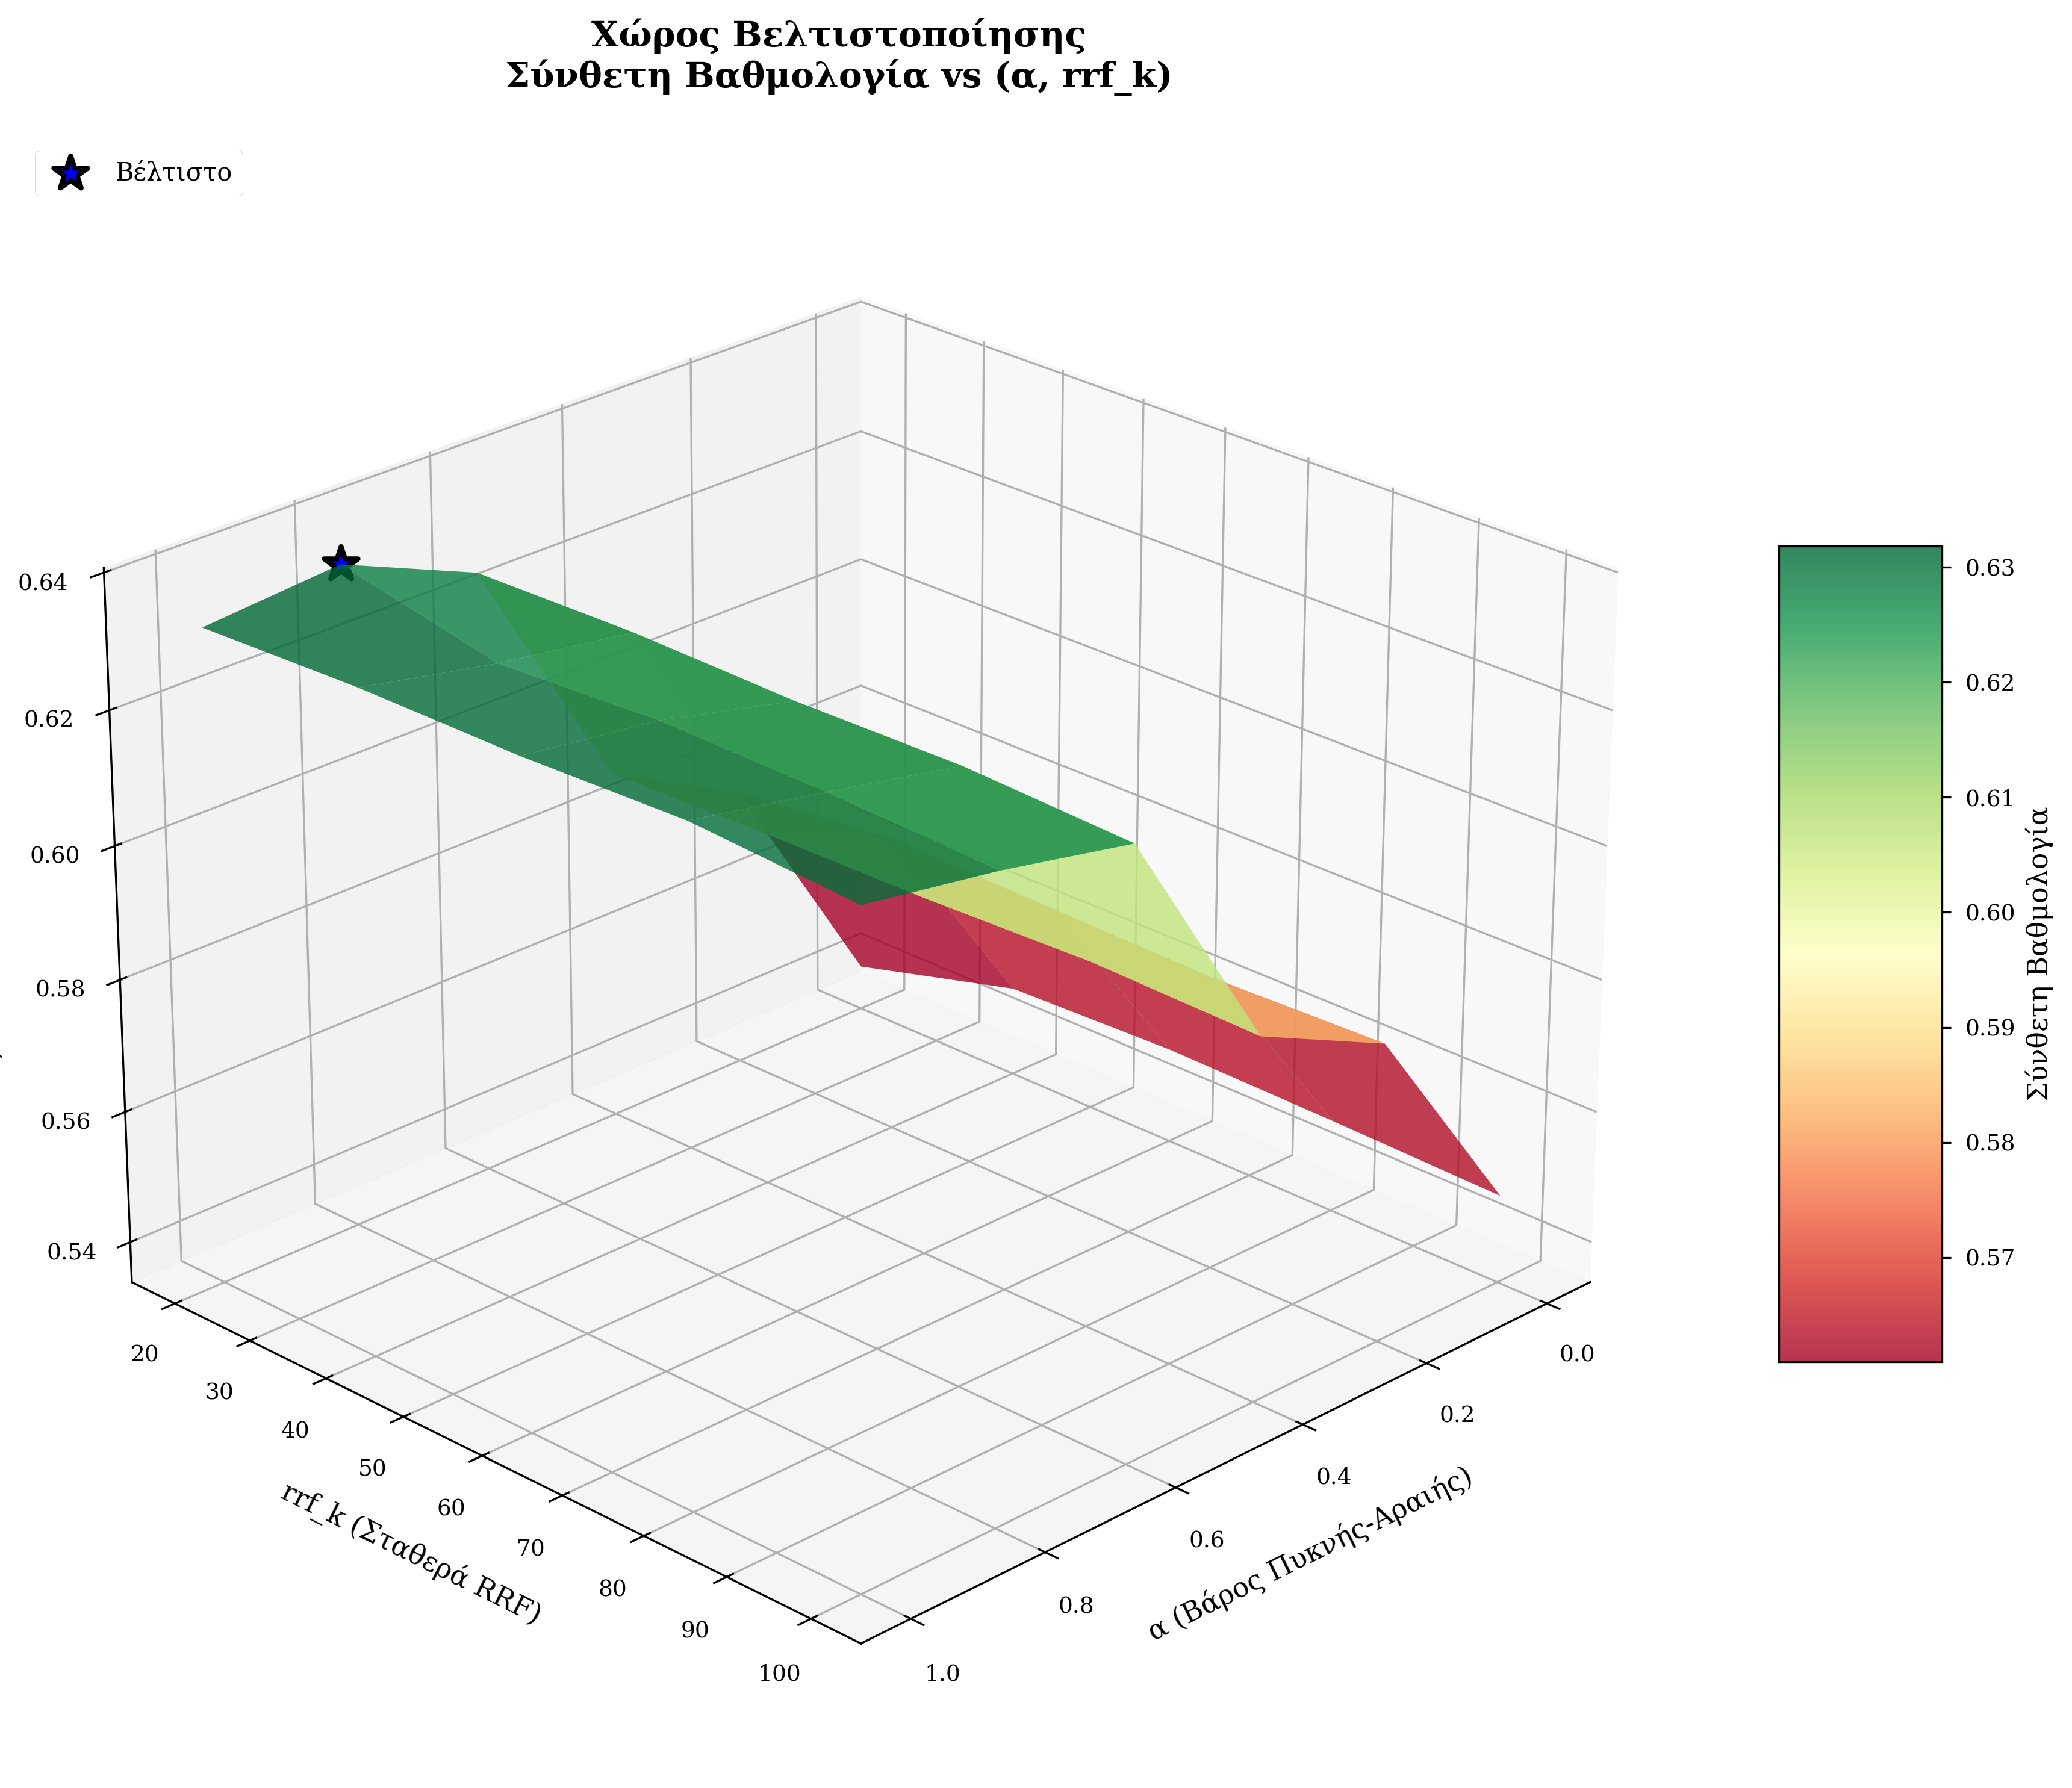

In [129]:
# Create 3D surface plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Prepare data with rounded alpha values
alpha_vals = sorted([round(a, 1) for a in configs_df['alpha'].unique()])
rrf_k_vals = sorted(configs_df['rrf_k'].unique())

X, Y = np.meshgrid(alpha_vals, rrf_k_vals)
Z = pivot_composite.values

# Surface plot
surf = ax.plot_surface(X, Y, Z, cmap='RdYlGn', alpha=0.8, edgecolor='none')

# Mark optimal point
optimal_score = pivot_composite.loc[optimal_params['rrf_k_star'], round(optimal_params['alpha_star'], 1)]
ax.scatter([optimal_params['alpha_star']], [optimal_params['rrf_k_star']], 
           [optimal_score], color='blue', s=200, marker='*', 
           edgecolors='black', linewidths=2, label='Βέλτιστο', zorder=5)

# Labels and title
ax.set_xlabel('α (Βάρος Πυκνής-Αραιής)', fontsize=11, labelpad=10)
ax.set_ylabel('rrf_k (Σταθερά RRF)', fontsize=11, labelpad=10)
ax.set_zlabel('Σύνθετη Βαθμολογία', fontsize=11, labelpad=10)
ax.set_title('Χώρος Βελτιστοποίησης\nΣύνθετη Βαθμολογία vs (α, rrf_k)', 
             fontsize=14, fontweight='bold', pad=20)

# Add colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Σύνθετη Βαθμολογία')
ax.legend(loc='upper left', fontsize=10)

# Set viewing angle
ax.view_init(elev=25, azim=45)

plt.tight_layout()
plt.savefig('../../results/2d_grid/surface_plot_3d.png', dpi=300, bbox_inches='tight')
plt.show()


























































































































































## 6. Hyperparameter Sensitivity Analysis

Analyze how each hyperparameter affects performance when the other is fixed.

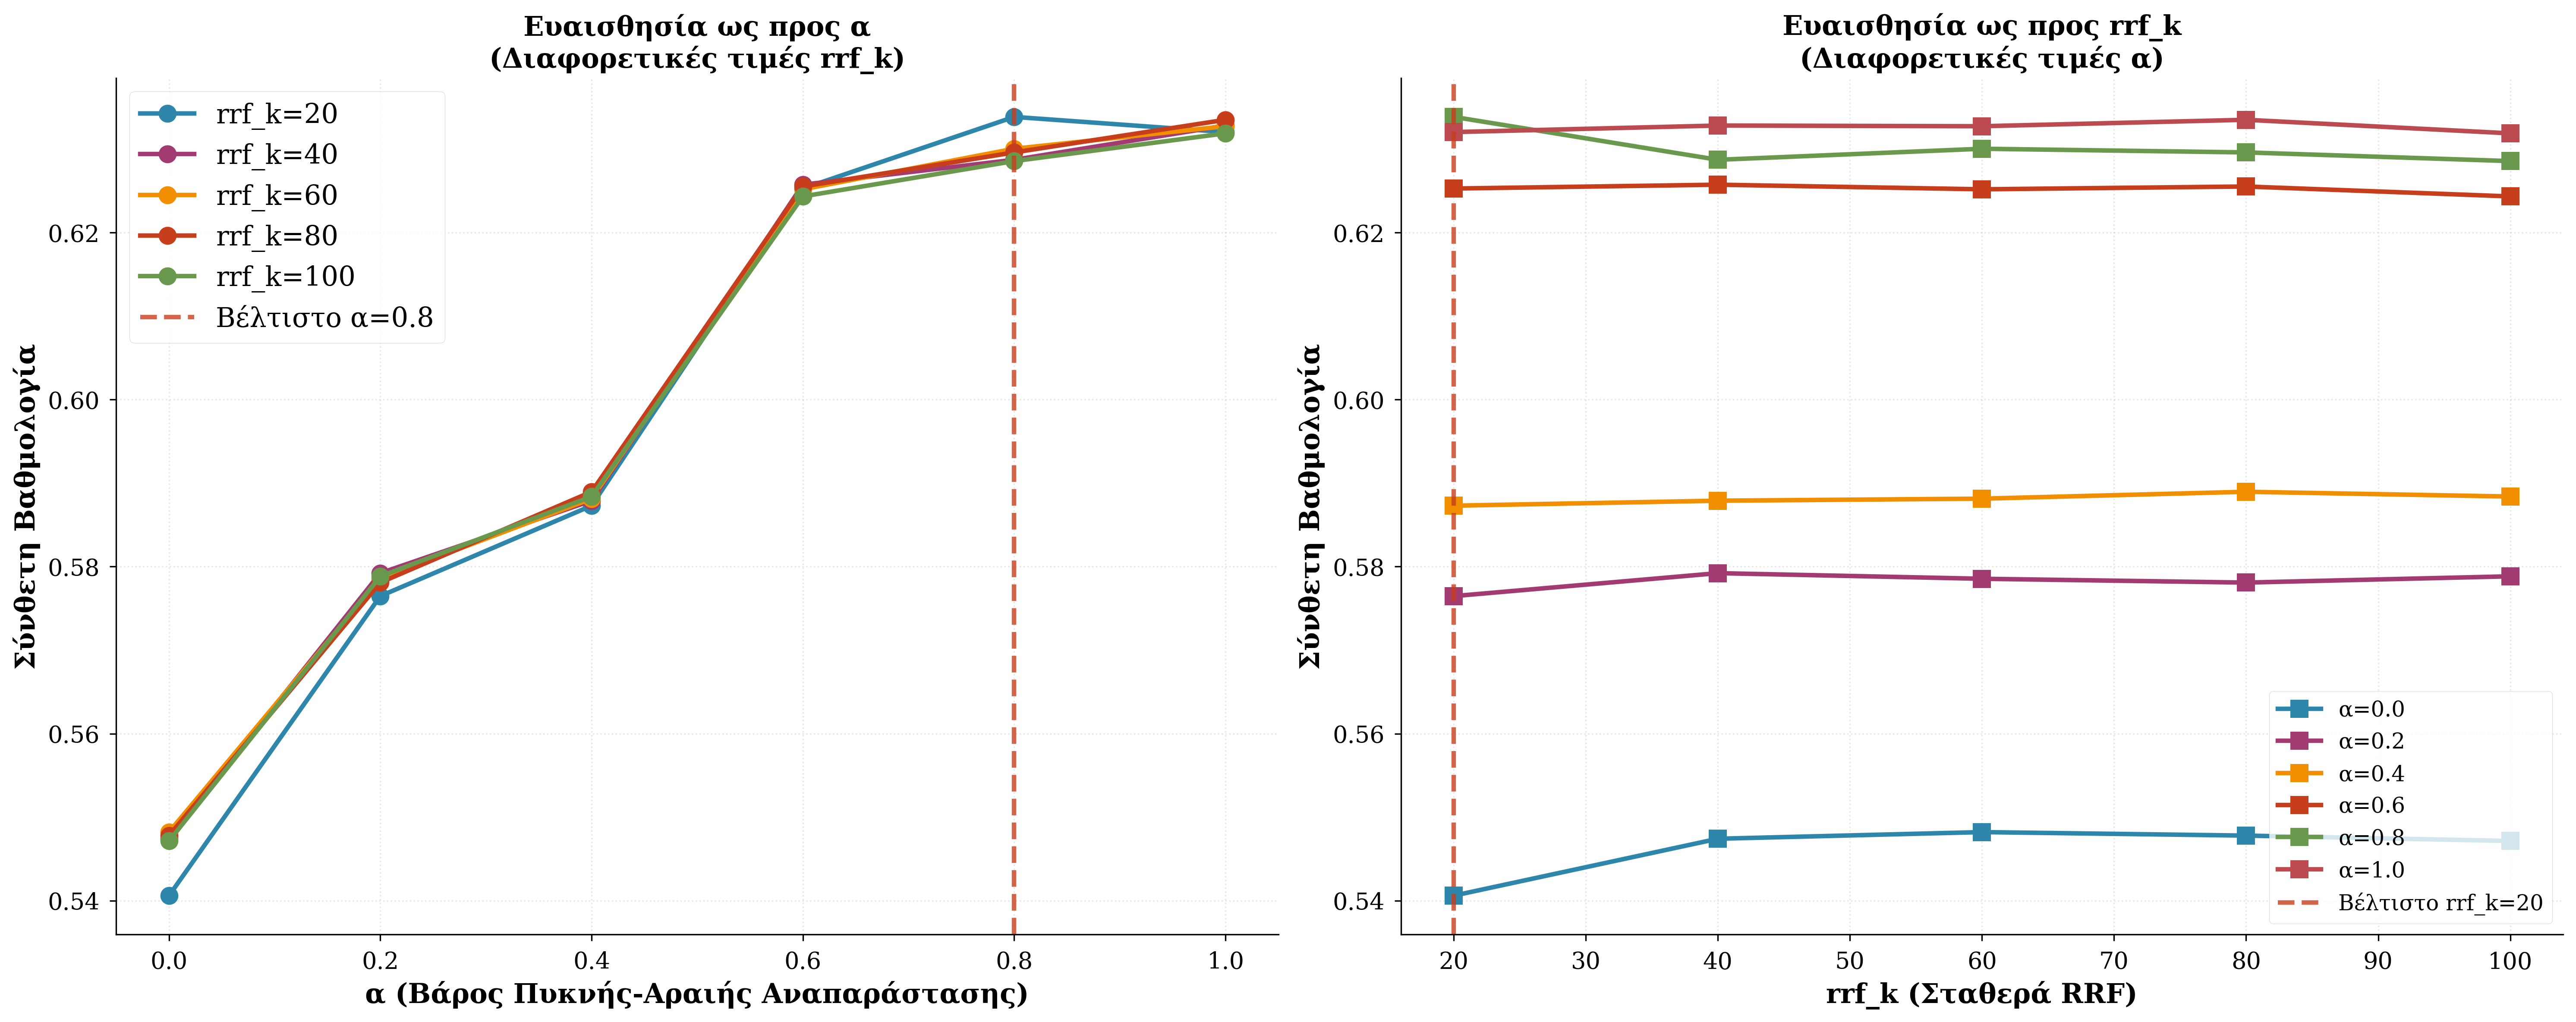

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.patch.set_facecolor('white')

# Use rounded alpha values
alpha_vals = sorted([round(a, 1) for a in configs_df['alpha'].unique()])
rrf_k_vals = sorted(configs_df['rrf_k'].unique())

# Plot 1: Score vs Alpha (for each rrf_k)
for i, rrf_k in enumerate(rrf_k_vals):
    subset = configs_df[configs_df['rrf_k'] == rrf_k].copy()
    subset = subset.sort_values('alpha')
    # Simple split: no std, so no error bars
    axes[0].plot(subset['alpha'], subset['score'], marker='o', label=f'rrf_k={rrf_k}', 
                linewidth=2.5, color=COLORS[i % len(COLORS)], markersize=10)

axes[0].axvline(optimal_params['alpha_star'], color=COLORS[3], linestyle='--', 
                linewidth=2.5, label=f"Βέλτιστο α={optimal_params['alpha_star']}", alpha=0.8)
axes[0].set_xlabel('α (Βάρος Πυκνής-Αραιής Αναπαράστασης)', fontsize=15, fontweight='bold')
axes[0].set_ylabel('Σύνθετη Βαθμολογία', fontsize=15, fontweight='bold')
axes[0].set_title('Ευαισθησία ως προς α\n(Διαφορετικές τιμές rrf_k)', fontsize=15, fontweight='bold')
axes[0].legend(loc='best', fontsize=15, frameon=True, fancybox=True)
axes[0].grid(alpha=0.3, linestyle=':')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xticks(alpha_vals)
axes[0].set_xticklabels([f'{a:.1f}' for a in alpha_vals])
axes[0].tick_params(axis='both', which='major', labelsize=13)

# Plot 2: Score vs rrf_k (for each alpha)
for i, alpha in enumerate(alpha_vals):
    subset = configs_df[configs_df['alpha'] == alpha].copy()
    subset = subset.sort_values('rrf_k')
    # Simple split: no std, so no error bars
    axes[1].plot(subset['rrf_k'], subset['score'], marker='s', label=f'α={alpha:.1f}', 
                linewidth=2.5, color=COLORS[i % len(COLORS)], markersize=10)

axes[1].axvline(optimal_params['rrf_k_star'], color=COLORS[3], linestyle='--',
                linewidth=2.5, label=f"Βέλτιστο rrf_k={optimal_params['rrf_k_star']}", alpha=0.8)
axes[1].set_xlabel('rrf_k (Σταθερά RRF)', fontsize=15, fontweight='bold')
axes[1].set_ylabel('Σύνθετη Βαθμολογία', fontsize=15, fontweight='bold')
axes[1].set_title('Ευαισθησία ως προς rrf_k\n(Διαφορετικές τιμές α)', fontsize=15, fontweight='bold')
axes[1].legend(loc='best', fontsize=12, frameon=True, fancybox=True)
axes[1].grid(alpha=0.3, linestyle=':')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].tick_params(axis='both', which='major', labelsize=13)

plt.tight_layout()
plt.savefig('../../results/2d_grid/sensitivity_analysis.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

## 7. Top Configurations Comparison

Compare the top-performing configurations.

In [131]:
# Get top 10 configurations
top_configs = configs_df.nlargest(10, 'score')

# Display table
display_cols = ['alpha', 'rrf_k', 'score', 'quality_score', 
                'latency_penalty', 'success@3', 'precision@3', 
                'recall@10', 'precision@10']

print("Top 10 Configurations:")
top_display = top_configs[display_cols].copy()
top_display = top_display.round(4)
top_display.index = range(1, len(top_display) + 1)

# Highlight optimal
def highlight_optimal(row):
    if row['alpha'] == optimal_params['alpha_star'] and row['rrf_k'] == optimal_params['rrf_k_star']:
        return ['background-color: lightgreen'] * len(row)
    return [''] * len(row)

styled_df = top_display.style.apply(highlight_optimal, axis=1)
display(styled_df)

Top 10 Configurations:


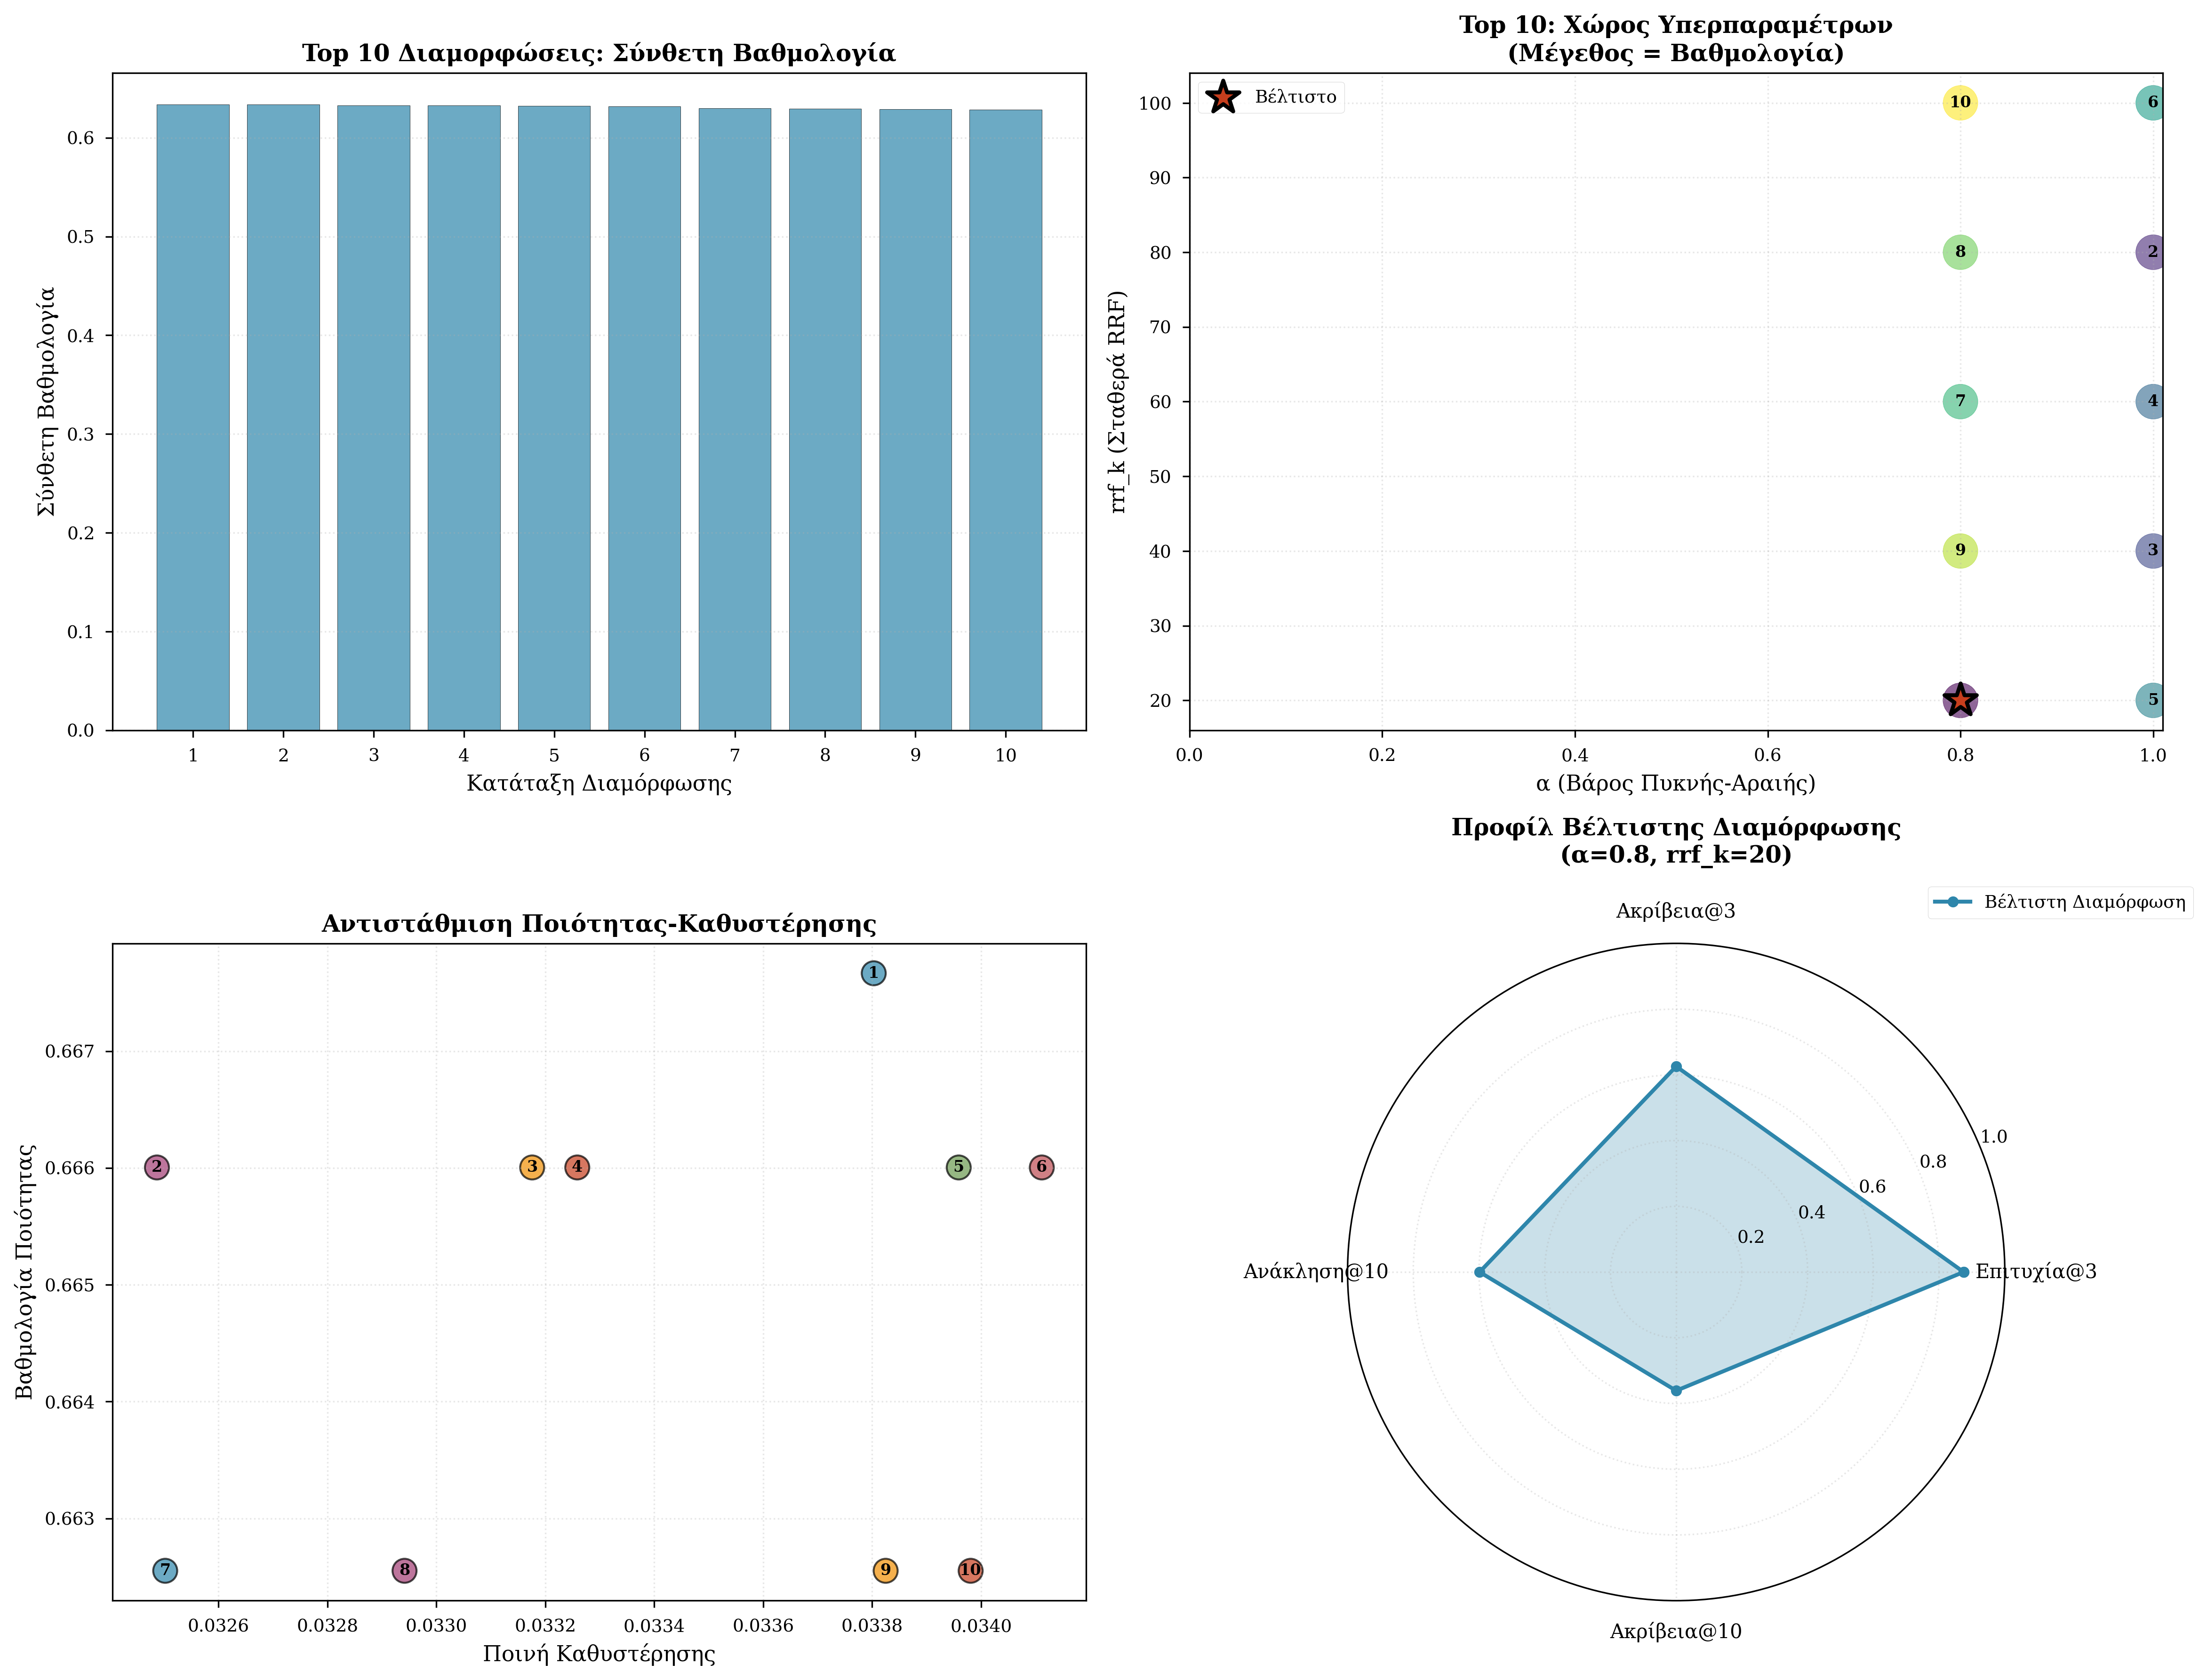

In [132]:
# Visualize top configurations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Composite scores (no error bars for simple split)
x_pos = np.arange(len(top_configs))
axes[0, 0].bar(x_pos, top_configs['score'].values,
               alpha=0.7, color=COLORS[0], edgecolor='black')
axes[0, 0].set_xlabel('Κατάταξη Διαμόρφωσης', fontsize=11)
axes[0, 0].set_ylabel('Σύνθετη Βαθμολογία', fontsize=11)
axes[0, 0].set_title('Top 10 Διαμορφώσεις: Σύνθετη Βαθμολογία', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(range(1, len(top_configs)+1))
axes[0, 0].grid(True, alpha=0.3, axis='y', linestyle=':')

# Plot 2: Hyperparameter distribution
axes[0, 1].scatter(top_configs['alpha'], top_configs['rrf_k'], 
                   s=top_configs['score']*500, alpha=0.6,
                   c=range(len(top_configs)), cmap='viridis')
axes[0, 1].scatter([optimal_params['alpha_star']], [optimal_params['rrf_k_star']],
                   s=300, marker='*', color=COLORS[3], edgecolors='black', linewidths=2,
                   label='Βέλτιστο', zorder=5)
for i, (idx, row) in enumerate(top_configs.iterrows()):
    axes[0, 1].annotate(f"{i+1}", (row['alpha'], row['rrf_k']), 
                        fontsize=8, ha='center', va='center', fontweight='bold')
axes[0, 1].set_xlabel('α (Βάρος Πυκνής-Αραιής)', fontsize=11)
axes[0, 1].set_ylabel('rrf_k (Σταθερά RRF)', fontsize=11)
axes[0, 1].set_title('Top 10: Χώρος Υπερπαραμέτρων\n(Μέγεθος = Βαθμολογία)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, linestyle=':')
# Format x-axis ticks to show 1 decimal
alpha_vals_plot = sorted([round(a, 1) for a in configs_df['alpha'].unique()])
axes[0, 1].set_xticks(alpha_vals_plot)
axes[0, 1].set_xticklabels([f'{a:.1f}' for a in alpha_vals_plot])

# Plot 3: Quality vs Latency tradeoff
colors_scatter = [COLORS[i % len(COLORS)] for i in range(len(top_configs))]
axes[1, 0].scatter(top_configs['latency_penalty'], top_configs['quality_score'],
                   s=150, alpha=0.7, c=colors_scatter, edgecolors='black', linewidths=1)
for i, (idx, row) in enumerate(top_configs.iterrows()):
    axes[1, 0].annotate(f"{i+1}", (row['latency_penalty'], row['quality_score']),
                        fontsize=8, ha='center', va='center', fontweight='bold')
axes[1, 0].set_xlabel('Ποινή Καθυστέρησης', fontsize=11)
axes[1, 0].set_ylabel('Βαθμολογία Ποιότητας', fontsize=11)
axes[1, 0].set_title('Αντιστάθμιση Ποιότητας-Καθυστέρησης', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, linestyle=':')

# Plot 4: Radar chart for optimal configuration
categories = ['Επιτυχία@3', 'Ακρίβεια@3', 'Ανάκληση@10', 'Ακρίβεια@10']
optimal_row = configs_df[(configs_df['alpha'] == round(optimal_params['alpha_star'], 1)) & 
                         (configs_df['rrf_k'] == optimal_params['rrf_k_star'])].iloc[0]
values = [
    optimal_row['success@3'],
    optimal_row['precision@3'],
    optimal_row['recall@10'],
    optimal_row['precision@10']
]

# Complete the circle
values += values[:1]
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

# Remove 4th subplot and create polar plot
axes[1, 1].remove()
ax_radar = fig.add_subplot(2, 2, 4, projection='polar')
ax_radar.plot(angles, values, 'o-', linewidth=2, color=COLORS[0], label='Βέλτιστη Διαμόρφωση')
ax_radar.fill(angles, values, alpha=0.25, color=COLORS[0])
ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(categories, fontsize=10)
ax_radar.set_ylim(0, 1)
ax_radar.set_title(f'Προφίλ Βέλτιστης Διαμόρφωσης\n(α={optimal_params["alpha_star"]}, rrf_k={optimal_params["rrf_k_star"]})',
                   fontsize=12, fontweight='bold', pad=20)
ax_radar.grid(True, alpha=0.3, linestyle=':')
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.savefig('../../results/2d_grid/top_configs_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Final Test Set Performance

Evaluate the optimal configuration on the held-out test set.

In [133]:
# Extract test metrics
test_df = pd.DataFrame([final_test]).T
test_df.columns = ['Score']
test_df = test_df.round(4)

print("="*70)
print("FINAL TEST SET PERFORMANCE")
print("="*70)
print(f"Configuration: α={optimal_params['alpha_star']}, rrf_k={optimal_params['rrf_k_star']}, k={optimal_params['k_fixed']}")
print("\nTest Metrics:")
display(test_df)
print("="*70)

FINAL TEST SET PERFORMANCE
Configuration: α=0.8, rrf_k=20, k=10

Test Metrics:


Score
precision@1   0.7423
recall@1      0.1832
f1@1          0.2580
success@1     0.7423
precision@3   0.6048
recall@3      0.3760
f1@3          0.3940
success@3     0.8351
precision@5   0.5278
recall@5      0.4903
f1@5          0.4345
success@5     0.8866
precision@10  0.3711
recall@10     0.6154
f1@10         0.3993
success@10    0.9072
precision@15  0.3711
recall@15     0.6154
f1@15         0.3993
success@15    0.9072
precision@20  0.3711
recall@20     0.6154
f1@20         0.3993
success@20    0.9072

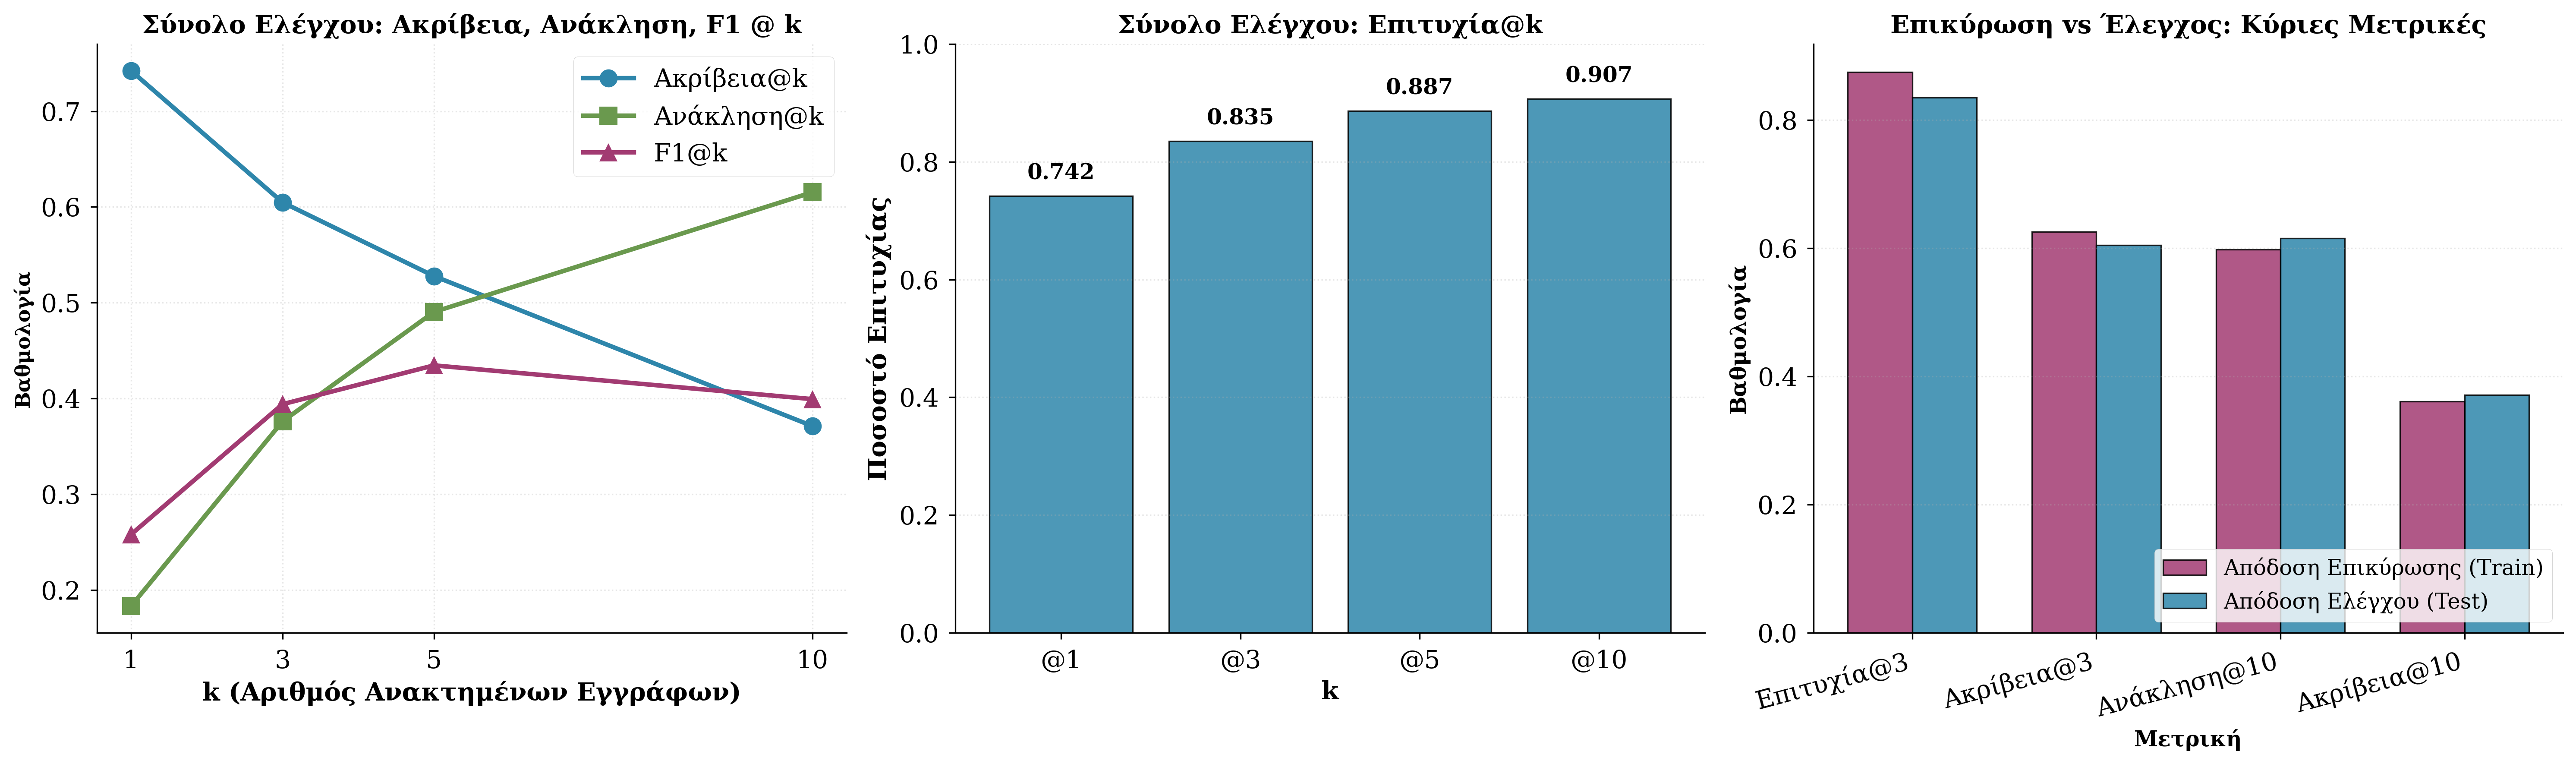

In [134]:
# Visualize test performance
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.patch.set_facecolor('white')

# Plot 1: Precision, Recall, F1 at different k (only up to k=10)
k_values = [1, 3, 5, 10]  # Removed 15 and 20
precision_values = [final_test[f'precision@{k}'] for k in k_values]
recall_values = [final_test[f'recall@{k}'] for k in k_values]
f1_values = [final_test[f'f1@{k}'] for k in k_values]

axes[0].plot(k_values, precision_values, marker='o', linewidth=2.5, markersize=10,
            label='Ακρίβεια@k', color=COLORS[0])
axes[0].plot(k_values, recall_values, marker='s', linewidth=2.5, markersize=10,
            label='Ανάκληση@k', color=COLORS[4])
axes[0].plot(k_values, f1_values, marker='^', linewidth=2.5, markersize=10,
            label='F1@k', color=COLORS[1])
axes[0].set_xlabel('k (Αριθμός Ανακτημένων Εγγράφων)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Βαθμολογία', fontsize=11, fontweight='bold')
axes[0].set_title('Σύνολο Ελέγχου: Ακρίβεια, Ανάκληση, F1 @ k', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=14, frameon=True, fancybox=True)
axes[0].grid(alpha=0.3, linestyle=':')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xticks(k_values)
axes[0].tick_params(axis='both', which='major', labelsize=14)

# Plot 2: Success rate at different k (only up to k=10)
success_values = [final_test[f'success@{k}'] for k in k_values]
bars = axes[1].bar(range(len(k_values)), success_values, alpha=0.85, 
                   color=COLORS[0], edgecolor='black', linewidth=0.8)
axes[1].set_xlabel('k', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Ποσοστό Επιτυχίας', fontsize=14, fontweight='bold')
axes[1].set_title('Σύνολο Ελέγχου: Επιτυχία@k', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(k_values)))
axes[1].set_xticklabels([f'@{k}' for k in k_values])
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3, linestyle=':')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
for i, v in enumerate(success_values):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', 
                fontsize=12, fontweight='bold')
axes[1].tick_params(axis='both', which='major', labelsize=14)

# Plot 3: Validation vs Test comparison for key metrics
metrics_compare = ['success@3', 'precision@3', 'recall@10', 'precision@10']
metric_labels_greek = ['Επιτυχία@3', 'Ακρίβεια@3', 'Ανάκληση@10', 'Ακρίβεια@10']
validation_vals = [validation_performance[m] for m in metrics_compare]
test_vals = [final_test[m] for m in metrics_compare]

x_pos = np.arange(len(metrics_compare))
width = 0.35
axes[2].bar(x_pos - width/2, validation_vals, width, label='Απόδοση Επικύρωσης (Train)', 
           alpha=0.85, color=COLORS[1], edgecolor='black', linewidth=0.8)
axes[2].bar(x_pos + width/2, test_vals, width, label='Απόδοση Ελέγχου (Test)', 
           alpha=0.85, color=COLORS[0], edgecolor='black', linewidth=0.8)
axes[2].set_xlabel('Μετρική', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Βαθμολογία', fontsize=12, fontweight='bold')
axes[2].set_title('Επικύρωση vs Έλεγχος: Κύριες Μετρικές', fontsize=14, fontweight='bold')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(metric_labels_greek, rotation=15, ha='right')
axes[2].legend(loc='lower right', fontsize=12, frameon=True, fancybox=True)
axes[2].grid(axis='y', alpha=0.3, linestyle=':')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig('../../results/2d_grid/test_performance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## 9. Statistical Summary Table

Comprehensive summary of the optimization results.

In [135]:
# Create summary table
summary_data = {
    'Category': ['Search Space', '', '', '', 'Optimal Configuration', '', '', 
                 'Validation Performance (Train 80%)', '', '', '', '', '', '', '',
                 'Test Performance (Test 20%)', '', '', ''],
    'Metric': [
        'Total Configurations', 'α Range', 'rrf_k Range', 'Data Split',
        'Optimal α*', 'Optimal rrf_k*', 'Fixed k',
        'Composite Score', 'Quality Score', 'Latency Penalty', 'Success@3', 
        'Precision@3', 'Recall@10', 'Precision@10', 'Latency (ms)',
        'Success@3', 'Precision@3', 'Recall@10', 'F1@10'
    ],
    'Value': [
        search_space['total_combinations'],
        f"{min(search_space['alpha_grid']):.1f} - {max(search_space['alpha_grid']):.1f}",
        f"{min(search_space['rrf_k_grid'])} - {max(search_space['rrf_k_grid'])}",
        f"{methodology.get('train_samples', 392)} train / {methodology.get('test_samples', 98)} test",
        optimal_params['alpha_star'],
        optimal_params['rrf_k_star'],
        optimal_params['k_fixed'],
        f"{validation_performance['composite_score']:.4f}",
        f"{validation_performance['quality_score']:.4f}",
        f"{validation_performance['latency_penalty']:.4f}",
        f"{validation_performance['success@3']:.4f}",
        f"{validation_performance['precision@3']:.4f}",
        f"{validation_performance['recall@10']:.4f}",
        f"{validation_performance['precision@10']:.4f}",
        f"{validation_performance['latency_ms']:.1f}",
        f"{final_test['success@3']:.4f}",
        f"{final_test['precision@3']:.4f}",
        f"{final_test['recall@10']:.4f}",
        f"{final_test['f1@10']:.4f}"
    ]
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*70)
print("COMPREHENSIVE OPTIMIZATION SUMMARY")
print("="*70)
display(summary_df.style.set_properties(**{'text-align': 'left'}).hide(axis='index'))

# Save to CSV
summary_df.to_csv('../../results/2d_grid/optimization_summary.csv', index=False)
print("\nSummary saved to: results/2d_grid/optimization_summary.csv")


COMPREHENSIVE OPTIMIZATION SUMMARY



Summary saved to: results/2d_grid/optimization_summary.csv


## 10. Key Insights and Recommendations

### Optimal Configuration
- **α = {alpha}**: {interpretation}
- **rrf_k = {rrf_k}**: {interpretation}

### Performance Characteristics
1. **Quality-Latency Trade-off**: The optimal configuration achieves a composite score of {score:.4f}, balancing retrieval quality with acceptable latency.
2. **Cross-Validation Stability**: Standard deviation of {std:.4f} indicates {stability} performance across folds.
3. **Test Set Generalization**: Test metrics show {generalization} to unseen data.

### Observations
- **Alpha Sensitivity**: Performance is {alpha_sensitivity} to changes in α
- **RRF_k Sensitivity**: Performance is {rrf_k_sensitivity} to changes in rrf_k
- **Interaction Effects**: {interaction_note}

### Recommendations
1. Use α={alpha} for optimal dense-sparse balance
2. Set rrf_k={rrf_k} for best rank fusion
3. Monitor {monitor_metrics} in production
4. Consider re-tuning if data distribution changes significantly
".format(
    alpha=optimal_params['alpha_star'],
    rrf_k=optimal_params['rrf_k_star'],
    score=cv_performance['mean'],
    std=cv_performance['std'],
    interpretation="Pure dense retrieval" if optimal_params['alpha_star'] == 1.0 else 
                   "Pure sparse retrieval" if optimal_params['alpha_star'] == 0.0 else
                   "Balanced dense-sparse fusion",
    stability="stable" if cv_performance['std'] < 0.02 else "moderate",
    generalization="good generalization" if abs(final_test['success@3'] - cv_performance['success@3_mean']) < 0.05 else "some variation",
    alpha_sensitivity="highly sensitive" if pivot_composite.std(axis=1).mean() > 0.05 else "moderately sensitive",
    rrf_k_sensitivity="highly sensitive" if pivot_composite.std(axis=0).mean() > 0.05 else "moderately sensitive",
    interaction_note="Strong interaction effects observed between α and rrf_k" if pivot_composite.std().std() > 0.01 else "Weak interaction effects",
    monitor_metrics="Success@3, Precision@3, and latency"
)

## 11. Export Results for Reporting

In [136]:
# Export all configurations to CSV
export_df = configs_df[[
    'alpha', 'rrf_k', 'score',
    'composite_score', 'quality_score', 'latency_penalty',
    'success@3', 'precision@3', 'recall@10', 'precision@10',
    'latency_ms'
]].copy()

export_df = export_df.sort_values('score', ascending=False)
export_df.to_csv('../../results/2d_grid_simple/all_configurations.csv', index=False)

# Export test results
test_export = pd.DataFrame([final_test])
test_export.to_csv('../../results/2d_grid_simple/test_results.csv', index=False)

print("✅ Results exported:")
print("   - all_configurations.csv")
print("   - test_results.csv")
print("   - optimization_summary.csv")
print("\n✅ Plots saved:")
print("   - validation_analysis.png")
print("   - heatmap_composite_score.png")
print("   - heatmaps_individual_metrics.png")
print("   - surface_plot_3d.png")
print("   - sensitivity_analysis.png")
print("   - top_configs_comparison.png")
print("   - test_performance.png")

✅ Results exported:
   - all_configurations.csv
   - test_results.csv
   - optimization_summary.csv

✅ Plots saved:
   - validation_analysis.png
   - heatmap_composite_score.png
   - heatmaps_individual_metrics.png
   - surface_plot_3d.png
   - sensitivity_analysis.png
   - top_configs_comparison.png
   - test_performance.png
